# Machine Failure Classifier
1.	UID: unique identifier ranging from 1 to 10000
2.	product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
3.	type: just the product type L, M or H from column 2
4.	air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
5.	process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
6.	rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
7.	torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
8.	tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
9.	a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.
The machine failure consists of five independent failure modes

1.	tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
2.	heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
3.	power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4.	overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
5.	random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.
If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.


# Import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, make_scorer,recall_score,precision_score, plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

import pickle

import warnings
warnings.filterwarnings("ignore")

# Data Exploration

In [2]:
df = pd.read_csv('..\\ai4i2020.csv')

In [3]:
df

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
0                       1551         42.8                0                0   
1                       1408         46.3                3                0   
2                       1498         49.4                5                0   
3                       1433         39.5                7                0   
4                       1408         40.0                9                0   
...                      ...          ...              ...              ...   
9995                    1604         29.5               14                0   
9996                    1632         31.8               17                0   
9997                    1645         33.4               22                0   
9998                    1408         48.5               25                0   
9999                    1500         40.2               30                0   

      TWF  HDF  PWF  OSF  RNF  
0       0    0    0    0    0  
1       0    0    0    0    0  
2       0    0    0    0    0  
3       0    0    0    0    0  
4       0    0    0    0    0  
...   ...  ...  ...  ...  ...  
9995    0    0    0    0    0  
9996    0    0    0    0    0  
9997    0    0    0    0    0  
9998    0    0    0    0    0  
9999    0    0    0    0    0  

[10000 rows x 14 columns]

In [4]:
df.rename(columns=lambda x: x.replace(" ", "_") , inplace=True)
df.rename(columns=lambda x: x.lower() , inplace=True)
df = df.assign(type=df["type"], air_temperature=df["air_temperature_[k]"], process_temperature=df["process_temperature_[k]"], rotational_speed=df["rotational_speed_[rpm]"], torque=df["torque_[nm]"], tool_wear=df["tool_wear_[min]"])
df.drop(columns= [ 'air_temperature_[k]',
 'process_temperature_[k]',
 'rotational_speed_[rpm]',
 'torque_[nm]',
 'tool_wear_[min]'] , inplace=True)



## Attribute Creation

In [5]:
df['power']=(df['rotational_speed']/60)*(6.28)*df['torque']
df['tool_torque']= df['tool_wear']*df['torque']
df['delta_temperature']= df['air_temperature']-df['process_temperature']

In [6]:
df.describe()

udi  machine_failure           twf           hdf           pwf  \
count  10000.00000     10000.000000  10000.000000  10000.000000  10000.000000   
mean    5000.50000         0.033900      0.004600      0.011500      0.009500   
std     2886.89568         0.180981      0.067671      0.106625      0.097009   
min        1.00000         0.000000      0.000000      0.000000      0.000000   
25%     2500.75000         0.000000      0.000000      0.000000      0.000000   
50%     5000.50000         0.000000      0.000000      0.000000      0.000000   
75%     7500.25000         0.000000      0.000000      0.000000      0.000000   
max    10000.00000         1.000000      1.000000      1.000000      1.000000   

                osf          rnf  air_temperature  process_temperature  \
count  10000.000000  10000.00000     10000.000000         10000.000000   
mean       0.009800      0.00190       300.004930           310.005560   
std        0.098514      0.04355         2.000259             1.483734   
min        0.000000      0.00000       295.300000           305.700000   
25%        0.000000      0.00000       298.300000           308.800000   
50%        0.000000      0.00000       300.100000           310.100000   
75%        0.000000      0.00000       301.500000           311.100000   
max        1.000000      1.00000       304.500000           313.800000   

       rotational_speed        torque     tool_wear        power  \
count      10000.000000  10000.000000  10000.000000  10000.00000   
mean        1538.776100     39.986910    107.951000   6276.56139   
std          179.284096      9.968934     63.654147   1066.87716   
min         1168.000000      3.800000      0.000000   1147.85840   
25%         1423.000000     33.200000     53.000000   5558.36520   
50%         1503.000000     40.100000    108.000000   6267.84820   
75%         1612.000000     46.800000    162.000000   6999.45250   
max         2886.000000     76.600000    253.000000  10464.61520   

        tool_torque  delta_temperature  
count  10000.000000       10000.000000  
mean    4314.664550         -10.000630  
std     2826.567692           1.001094  
min        0.000000         -12.100000  
25%     1963.650000         -11.000000  
50%     4012.950000          -9.800000  
75%     6279.000000          -9.300000  
max    16497.000000          -7.600000

In [7]:
df['delta_temperature']= df['delta_temperature']* (-1)

In [8]:
df.describe()

udi  machine_failure           twf           hdf           pwf  \
count  10000.00000     10000.000000  10000.000000  10000.000000  10000.000000   
mean    5000.50000         0.033900      0.004600      0.011500      0.009500   
std     2886.89568         0.180981      0.067671      0.106625      0.097009   
min        1.00000         0.000000      0.000000      0.000000      0.000000   
25%     2500.75000         0.000000      0.000000      0.000000      0.000000   
50%     5000.50000         0.000000      0.000000      0.000000      0.000000   
75%     7500.25000         0.000000      0.000000      0.000000      0.000000   
max    10000.00000         1.000000      1.000000      1.000000      1.000000   

                osf          rnf  air_temperature  process_temperature  \
count  10000.000000  10000.00000     10000.000000         10000.000000   
mean       0.009800      0.00190       300.004930           310.005560   
std        0.098514      0.04355         2.000259             1.483734   
min        0.000000      0.00000       295.300000           305.700000   
25%        0.000000      0.00000       298.300000           308.800000   
50%        0.000000      0.00000       300.100000           310.100000   
75%        0.000000      0.00000       301.500000           311.100000   
max        1.000000      1.00000       304.500000           313.800000   

       rotational_speed        torque     tool_wear        power  \
count      10000.000000  10000.000000  10000.000000  10000.00000   
mean        1538.776100     39.986910    107.951000   6276.56139   
std          179.284096      9.968934     63.654147   1066.87716   
min         1168.000000      3.800000      0.000000   1147.85840   
25%         1423.000000     33.200000     53.000000   5558.36520   
50%         1503.000000     40.100000    108.000000   6267.84820   
75%         1612.000000     46.800000    162.000000   6999.45250   
max         2886.000000     76.600000    253.000000  10464.61520   

        tool_torque  delta_temperature  
count  10000.000000       10000.000000  
mean    4314.664550          10.000630  
std     2826.567692           1.001094  
min        0.000000           7.600000  
25%     1963.650000           9.300000  
50%     4012.950000           9.800000  
75%     6279.000000          11.000000  
max    16497.000000          12.100000

In [9]:
print(df.count())
df.dropna()
print(df.count())

udi                    10000
product_id             10000
type                   10000
machine_failure        10000
twf                    10000
hdf                    10000
pwf                    10000
osf                    10000
rnf                    10000
air_temperature        10000
process_temperature    10000
rotational_speed       10000
torque                 10000
tool_wear              10000
power                  10000
tool_torque            10000
delta_temperature      10000
dtype: int64
udi                    10000
product_id             10000
type                   10000
machine_failure        10000
twf                    10000
hdf                    10000
pwf                    10000
osf                    10000
rnf                    10000
air_temperature        10000
process_temperature    10000
rotational_speed       10000
torque                 10000
tool_wear              10000
power                  10000
tool_torque            10000
delta_temperature      10000
d

In [10]:
df.describe(include='all')

udi product_id   type  machine_failure           twf  \
count   10000.00000      10000  10000     10000.000000  10000.000000   
unique          NaN      10000      3              NaN           NaN   
top             NaN     M14860      L              NaN           NaN   
freq            NaN          1   6000              NaN           NaN   
mean     5000.50000        NaN    NaN         0.033900      0.004600   
std      2886.89568        NaN    NaN         0.180981      0.067671   
min         1.00000        NaN    NaN         0.000000      0.000000   
25%      2500.75000        NaN    NaN         0.000000      0.000000   
50%      5000.50000        NaN    NaN         0.000000      0.000000   
75%      7500.25000        NaN    NaN         0.000000      0.000000   
max     10000.00000        NaN    NaN         1.000000      1.000000   

                 hdf           pwf           osf          rnf  \
count   10000.000000  10000.000000  10000.000000  10000.00000   
unique           NaN           NaN           NaN          NaN   
top              NaN           NaN           NaN          NaN   
freq             NaN           NaN           NaN          NaN   
mean        0.011500      0.009500      0.009800      0.00190   
std         0.106625      0.097009      0.098514      0.04355   
min         0.000000      0.000000      0.000000      0.00000   
25%         0.000000      0.000000      0.000000      0.00000   
50%         0.000000      0.000000      0.000000      0.00000   
75%         0.000000      0.000000      0.000000      0.00000   
max         1.000000      1.000000      1.000000      1.00000   

        air_temperature  process_temperature  rotational_speed        torque  \
count      10000.000000         10000.000000      10000.000000  10000.000000   
unique              NaN                  NaN               NaN           NaN   
top                 NaN                  NaN               NaN           NaN   
freq                NaN                  NaN               NaN           NaN   
mean         300.004930           310.005560       1538.776100     39.986910   
std            2.000259             1.483734        179.284096      9.968934   
min          295.300000           305.700000       1168.000000      3.800000   
25%          298.300000           308.800000       1423.000000     33.200000   
50%          300.100000           310.100000       1503.000000     40.100000   
75%          301.500000           311.100000       1612.000000     46.800000   
max          304.500000           313.800000       2886.000000     76.600000   

           tool_wear        power   tool_torque  delta_temperature  
count   10000.000000  10000.00000  10000.000000       10000.000000  
unique           NaN          NaN           NaN                NaN  
top              NaN          NaN           NaN                NaN  
freq             NaN          NaN           NaN                NaN  
mean      107.951000   6276.56139   4314.664550          10.000630  
std        63.654147   1066.87716   2826.567692           1.001094  
min         0.000000   1147.85840      0.000000           7.600000  
25%        53.000000   5558.36520   1963.650000           9.300000  
50%       108.000000   6267.84820   4012.950000           9.800000  
75%       162.000000   6999.45250   6279.000000          11.000000  
max       253.000000  10464.61520  16497.000000          12.100000

In [11]:
df = df.drop(columns=["udi","product_id","machine_failure"])

In [12]:
def get_class(row):
  # Crea una lista vuota per memorizzare i nomi delle colonne
  class_list = []
  # Itera su ogni colonna della riga
  for col in row.index:
    # Se il valore della colonna è 1, aggiungi il nome della colonna alla lista
    if row[col] == 1:
      class_list.append(col)
    
  if not class_list:
    #No Failures
    return "nf";
  # Trasforma la lista in una stringa, separando gli elementi con una virgola
  # Restituisci la stringa
  return class_list

df["class"] = df.apply(get_class, axis=1)

df['class'].value_counts()

nf                 9652
[hdf]               106
[pwf]                80
[osf]                78
[twf]                42
[rnf]                18
[pwf, osf]           11
[hdf, osf]            6
[hdf, pwf]            3
[twf, osf]            2
[twf, rnf]            1
[twf, pwf, osf]       1
Name: class, dtype: int64

In [13]:
def duplicate_row(df):
  # Crea una copia del dataframe per non modificare quello originale
  df_copy = df.copy()
  # Separa le liste in più righe, usando explode sulla colonna class
  df_copy = df_copy.explode("class")
  # Restituisci il dataframe modificato
  df_copy["class"] = df_copy["class"].str.strip()
  return df_copy

df = duplicate_row(df)
df.reset_index(inplace=True)

In [14]:
df.drop(columns =[
 'twf',
 'hdf',
 'pwf',
 'osf',
 'rnf'], inplace=True)

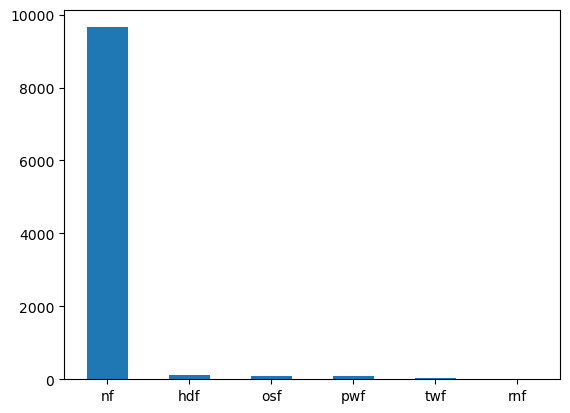

In [15]:
freq = df["class"].value_counts()
plt.bar(freq.index, freq.values, width=0.5)

plt.xticks(rotation=0)
plt.show()

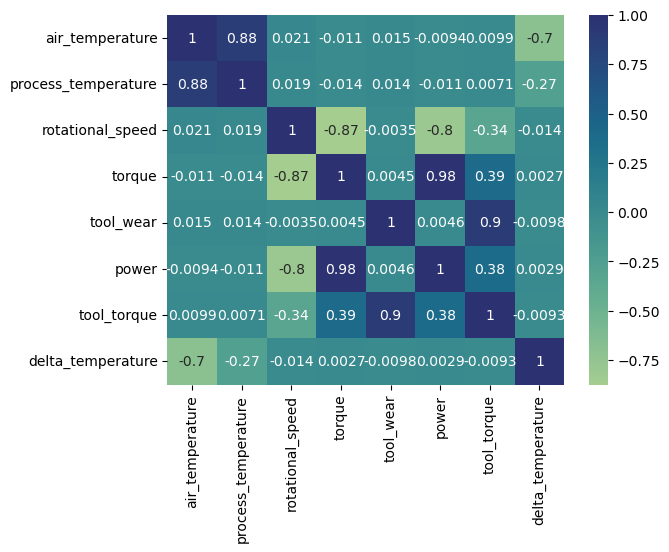

In [16]:
# Visualizza la matrice di correlazione
# Crea il grafico con sns.heatmap
sns.heatmap(df.drop(columns=["class","index"]).corr(), annot=True , cmap="crest")
# Mostra il grafico con plt.show
plt.show()

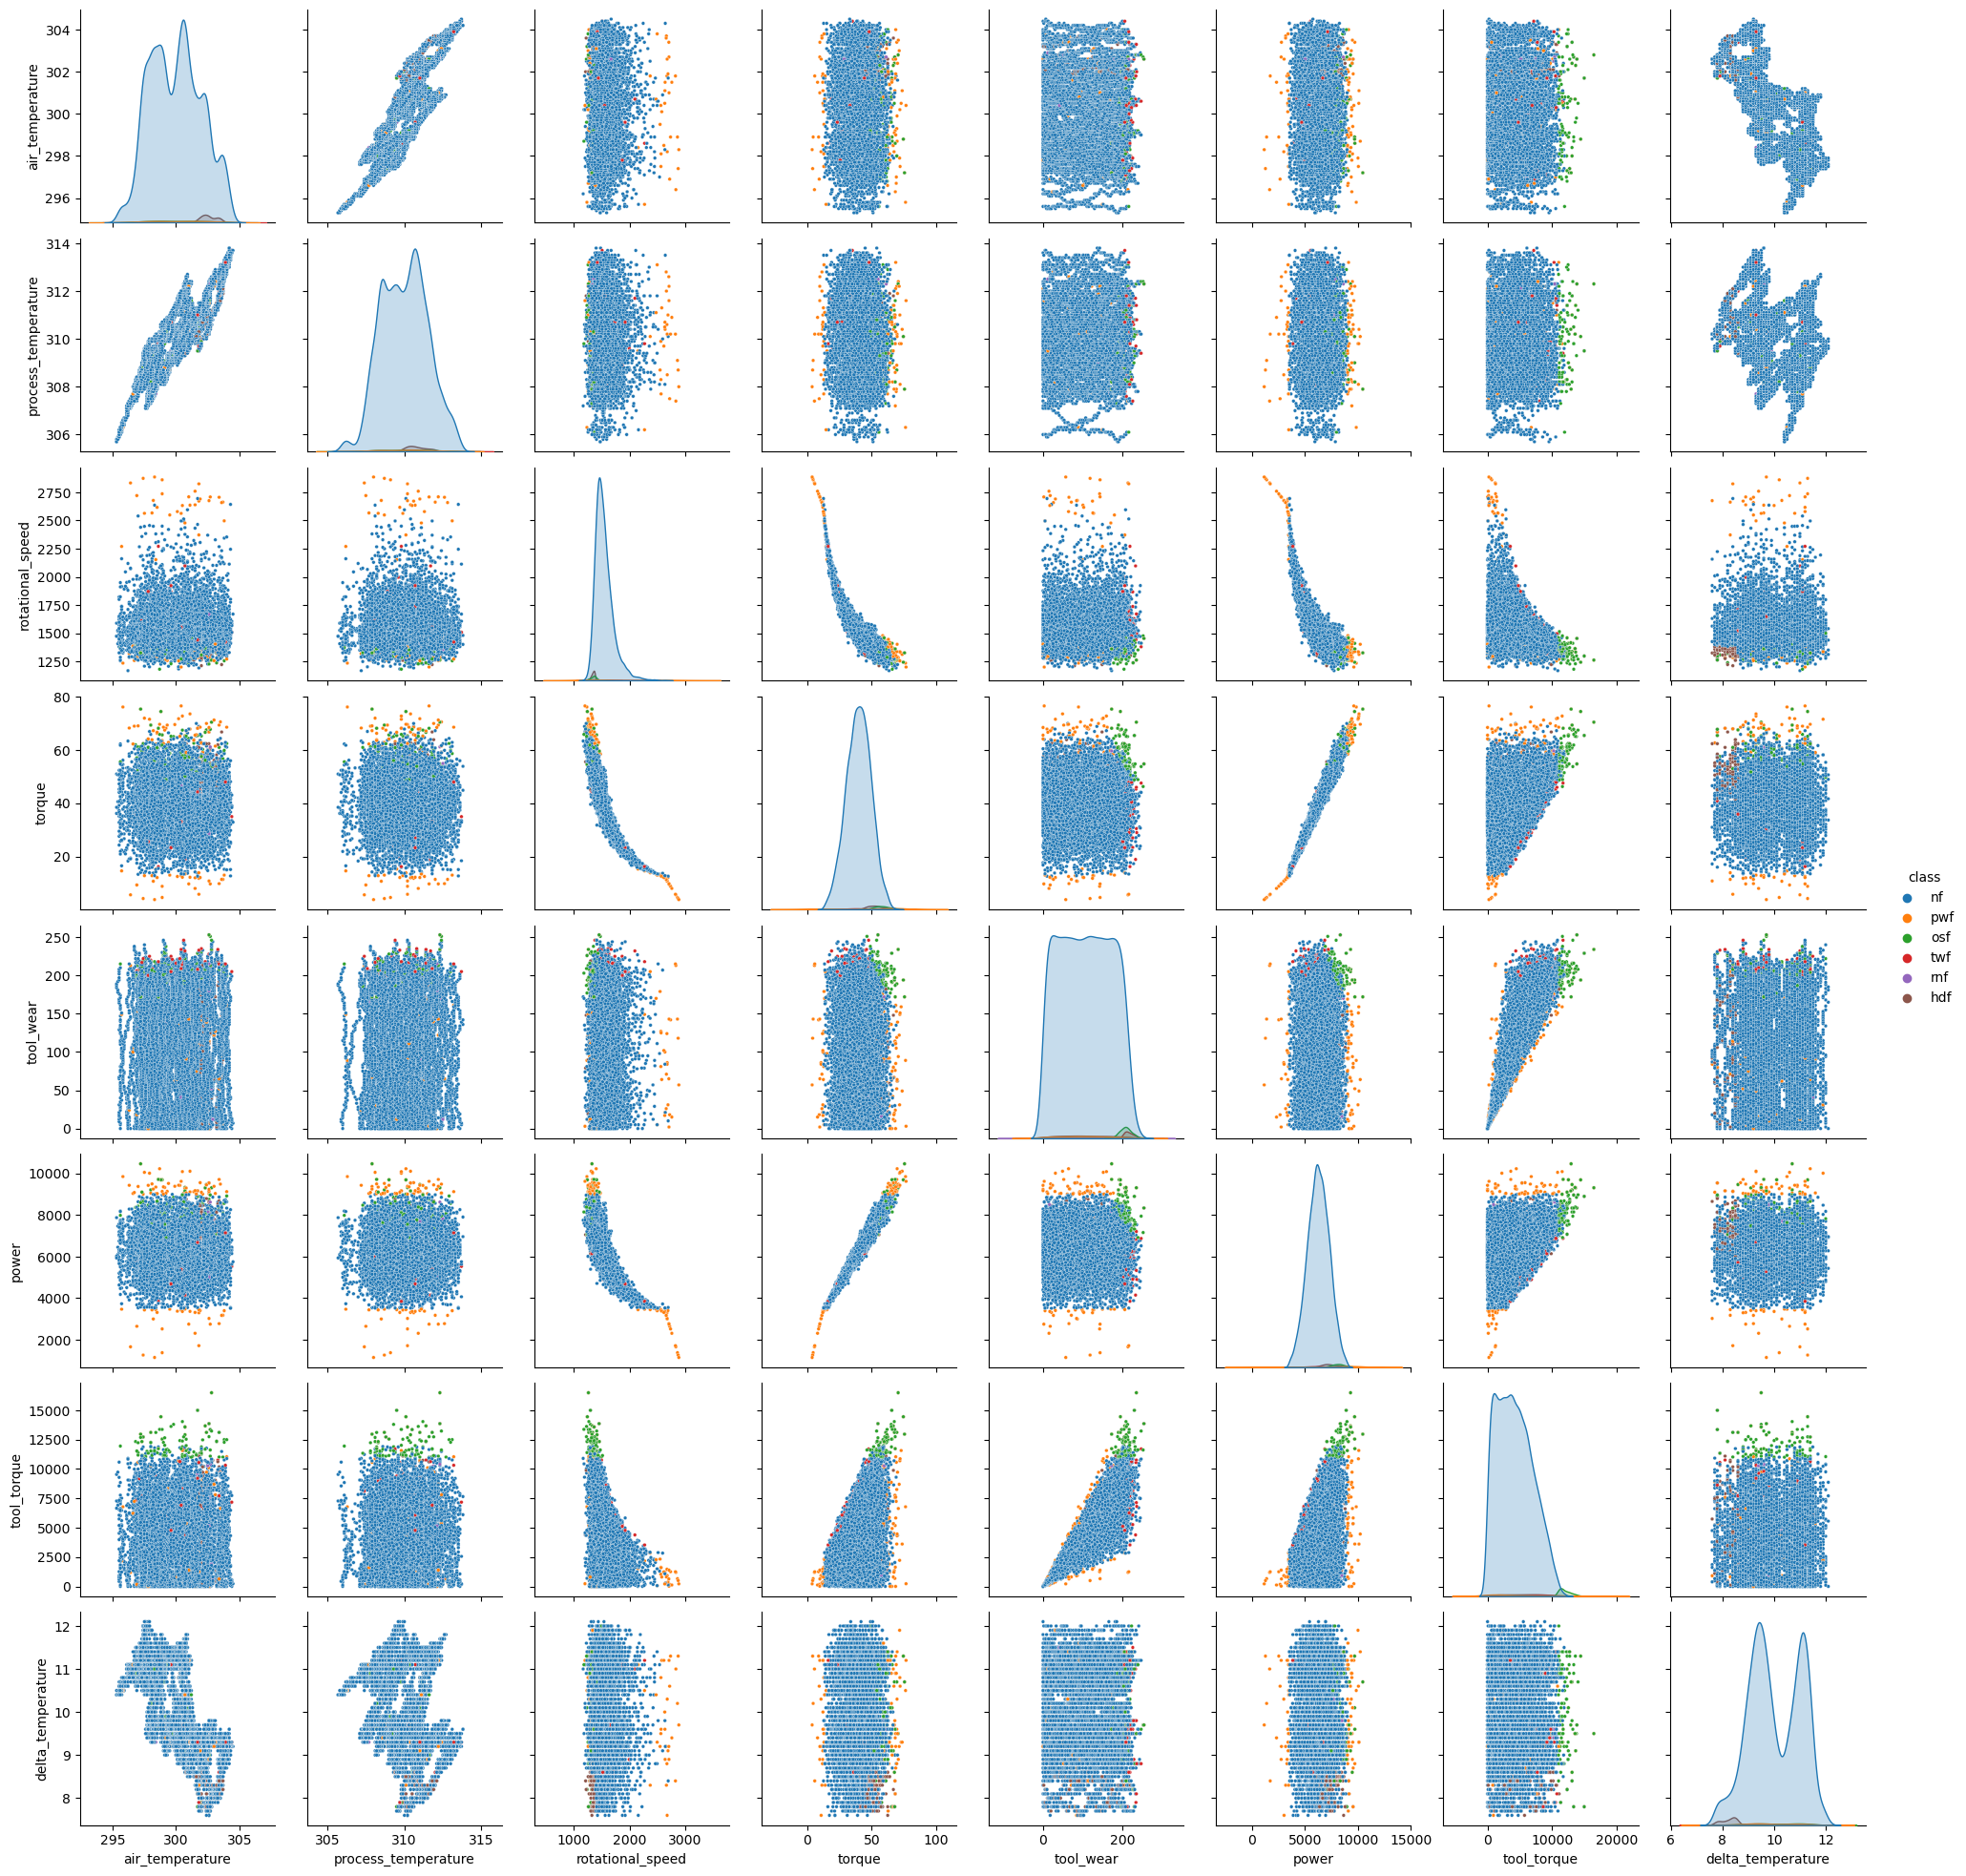

In [17]:
sns.pairplot(df.drop(columns=["index"]), plot_kws={"s": 7},hue="class")

In [18]:
df

index type  air_temperature  process_temperature  rotational_speed  \
0          0    M            298.1                308.6              1551   
1          1    L            298.2                308.7              1408   
2          2    L            298.1                308.5              1498   
3          3    L            298.2                308.6              1433   
4          4    L            298.2                308.7              1408   
...      ...  ...              ...                  ...               ...   
10020   9995    M            298.8                308.4              1604   
10021   9996    H            298.9                308.4              1632   
10022   9997    M            299.0                308.6              1645   
10023   9998    H            299.0                308.7              1408   
10024   9999    M            299.0                308.7              1500   

       torque  tool_wear        power  tool_torque  delta_temperature class  
0        42.8          0  6948.066400          0.0               10.5    nf  
1        46.3          3  6823.261867        138.9               10.5    nf  
2        49.4          5  7745.458933        247.0               10.4    nf  
3        39.5          7  5924.499667        276.5               10.4    nf  
4        40.0          9  5894.826667        360.0               10.5    nf  
...       ...        ...          ...          ...                ...   ...  
10020    29.5         14  4952.617333        413.0                9.6    nf  
10021    31.8         17  5431.948800        540.6                9.5    nf  
10022    33.4         22  5750.700667        734.8                9.6    nf  
10023    48.5         25  7147.477333       1212.5                9.7    nf  
10024    40.2         30  6311.400000       1206.0                9.7    nf  

[10025 rows x 11 columns]

In [19]:
df[df.tool_wear>240]

index type  air_temperature  process_temperature  rotational_speed  \
2865   2862    L            300.6                309.5              1867   
2866   2863    L            300.6                309.4              1471   
2867   2864    H            300.6                309.4              1380   
5413   5397    M            302.8                312.3              1416   
5414   5398    L            302.9                312.4              1923   
5415   5399    H            302.8                312.4              1411   
5416   5400    L            302.7                312.4              1477   
5417   5401    M            302.6                312.3              1454   
5418   5401    M            302.6                312.3              1454   
9693   9669    L            299.1                310.3              1619   
9694   9670    L            299.0                310.2              1690   
9695   9671    L            299.0                310.2              1412   

      torque  tool_wear        power  tool_torque  delta_temperature class  
2865    23.0        242  4494.491333       5566.0                8.9    nf  
2866    44.1        244  6789.841800      10760.4                8.8    nf  
2867    47.6        246  6875.344000      11709.6                8.8   twf  
5413    42.7        241  6328.481600      10290.7                9.5    nf  
5414    23.9        244  4810.448600       5831.6                9.5    nf  
5415    53.8        246  7945.435067      13234.8                9.6   osf  
5416    46.3        251  7157.640467      11621.3                9.7   osf  
5417    54.8        253  8339.756267      13864.4                9.7   twf  
5418    54.8        253  8339.756267      13864.4                9.7   osf  
9693    31.1        242  5270.060867       7526.2               11.2    nf  
9694    30.7        244  5430.420667       7490.8               11.2    nf  
9695    44.1        246  6517.509600      10848.6               11.2    nf

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_le = df.copy()
df_le["class"] = le.fit_transform(df["class"])
df_le["class"] = df_le["class"].astype(int)


def plot(column):
    for i in df_le["class"].unique():
        # Usa il metodo inverse_transform per ottenere le etichette originali
        label = le.inverse_transform([i])[0]
        sns.kdeplot(data=df_le[df_le["class"] == i][column], label = label)
    sns.kdeplot(data=df_le[column],label = ["All"])
    print(column)
    plt.legend()


def log_plot(column):
    for i in ['hdf', 'osf', 'pwf', 'twf','rnf']:
        sns.kdeplot(data=np.log(df[df["class"] == i][column]), label = le.inverse_transform([i]))
    sns.kdeplot(data=np.log(dfStars[column]),label = ["All"])
    plt.legend()

In [21]:
df.columns.tolist()

['index',
 'type',
 'air_temperature',
 'process_temperature',
 'rotational_speed',
 'torque',
 'tool_wear',
 'power',
 'tool_torque',
 'delta_temperature',
 'class']

<h3>Distribution of each useful attribute divided by class</h3>
This distribution will be useful for make a comparison with the dataset after the rebalance part

# Attributes Distribution
In the following steps, I see the distribution of each attribute, considering the separetion of each labeled-class. <br>
This is useful for understend the difference between each feature and what kind of attribute are more relevante for the aim of classification.

process_temperature


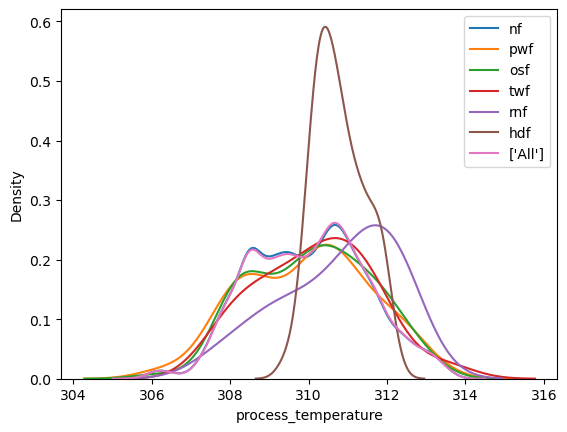

In [22]:
plot('process_temperature')
#plot('type')

air_temperature


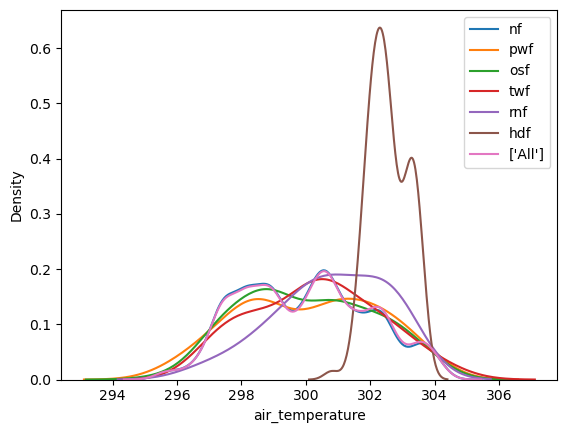

In [23]:
plot('air_temperature')

rotational_speed


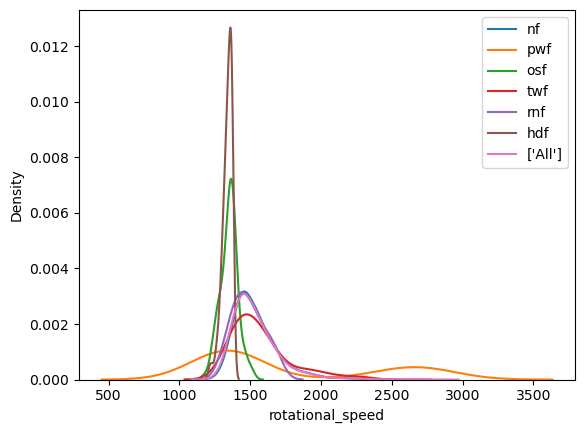

In [24]:
plot('rotational_speed')

torque


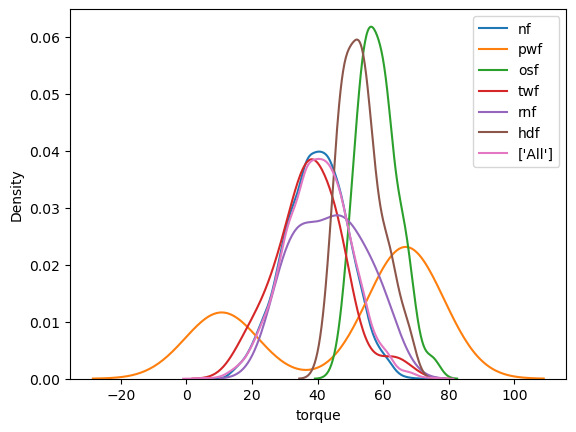

In [25]:
plot('torque')

tool_wear


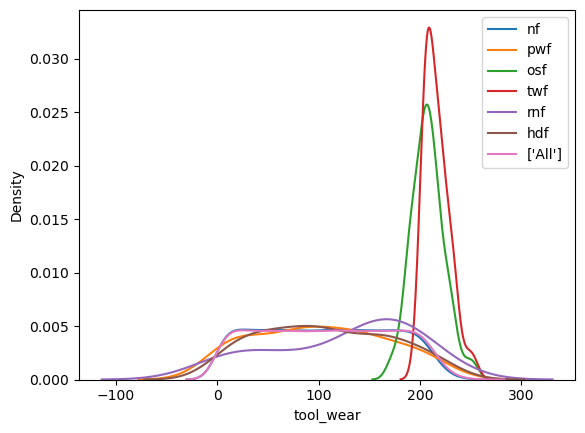

In [26]:
plot('tool_wear')

power


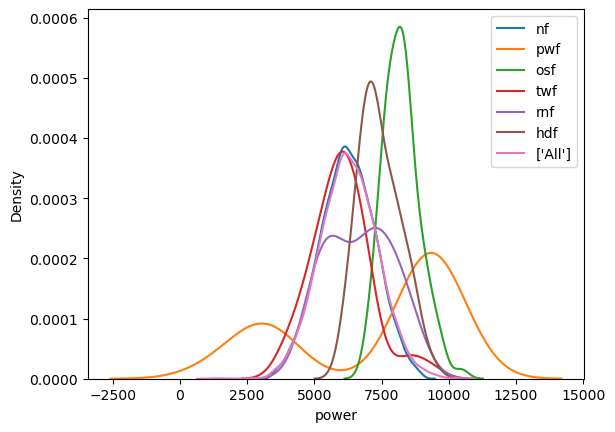

In [27]:
plot('power')

tool_torque


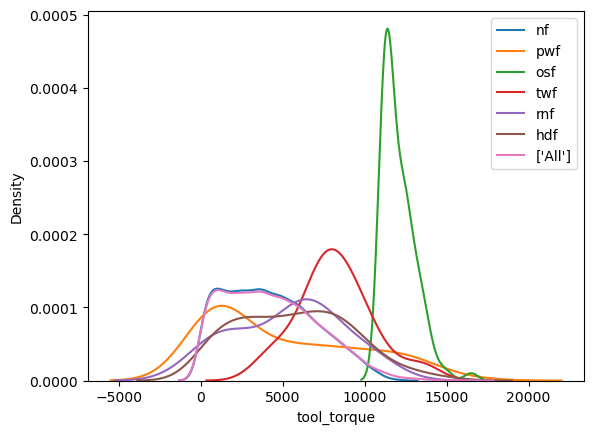

In [28]:
plot('tool_torque')

delta_temperature


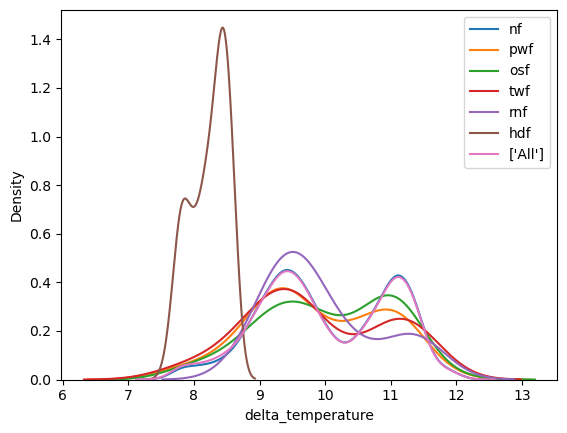

In [29]:
plot('delta_temperature')

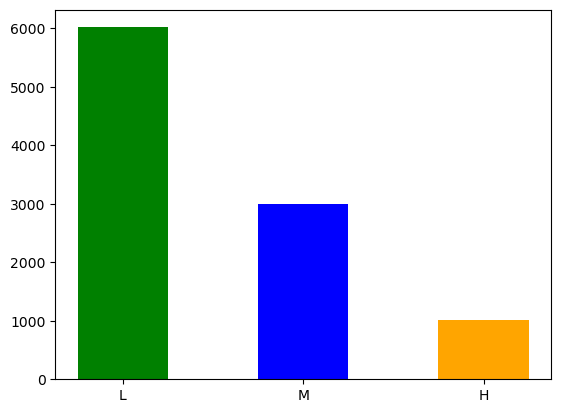

In [30]:
colors = [ "green", "blue", "orange"]
freq = df["type"].value_counts()
plt.bar(freq.index, freq.values, width=0.5, color=colors)

plt.xticks(rotation=0)
plt.show()

# Noise Handling

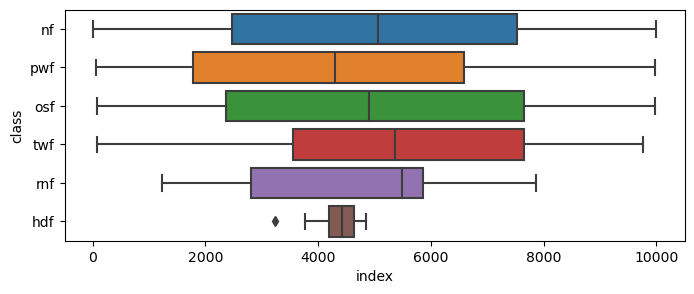

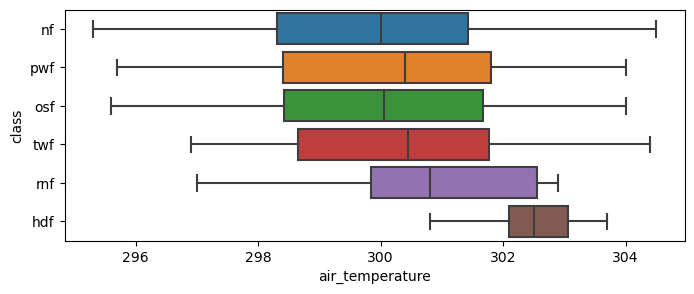

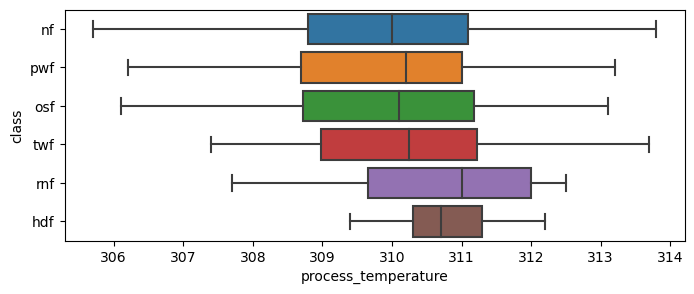

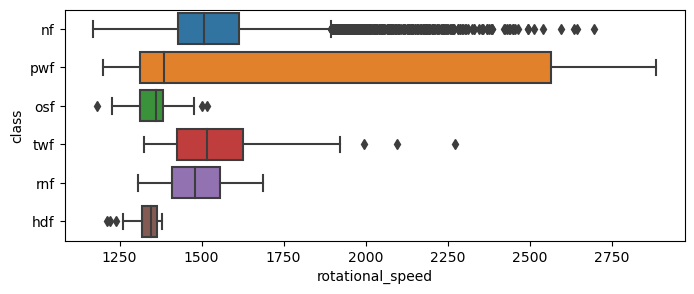

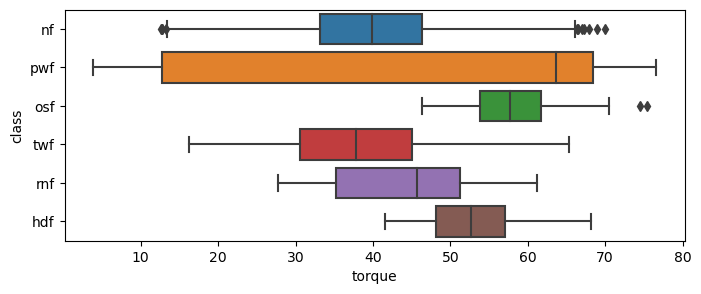

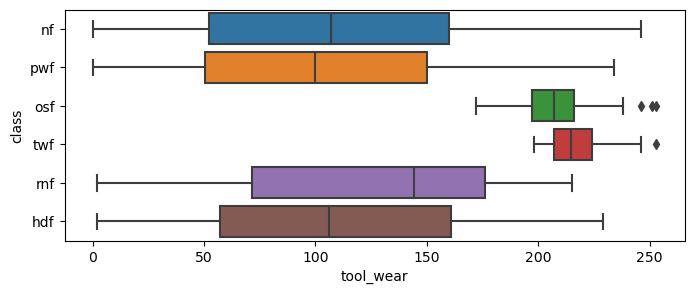

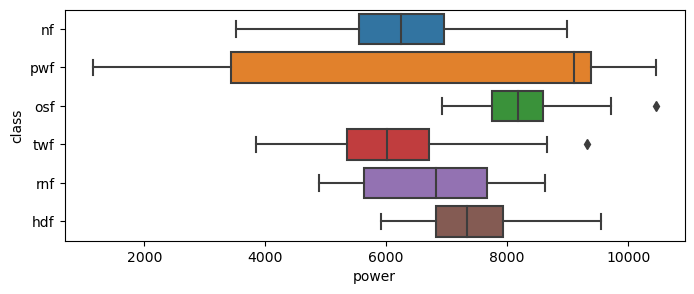

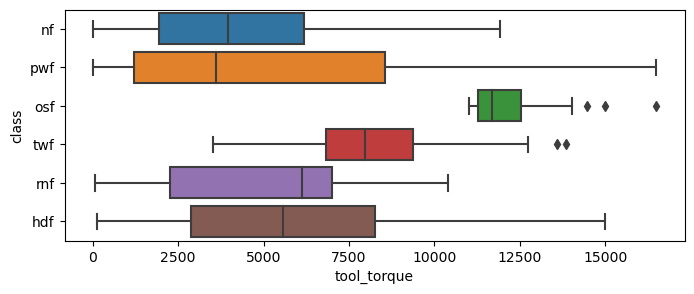

In [31]:
for att in df.drop(['class','type'], axis=1).columns[:-1]:
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=df[att], y=df['class'])
    plt.show()

As the boxplots show, there are no significant outliers, since there are no points that deviate much from the average values.

index


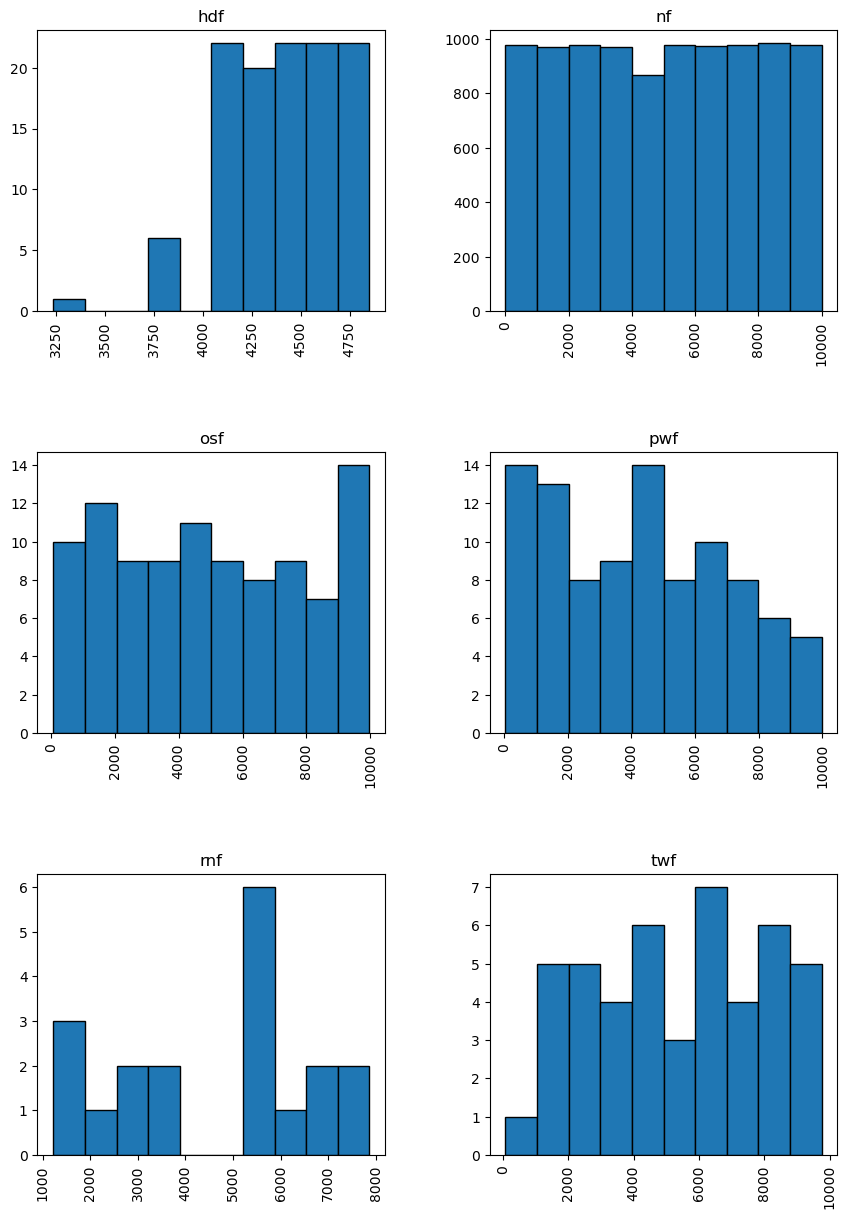

type


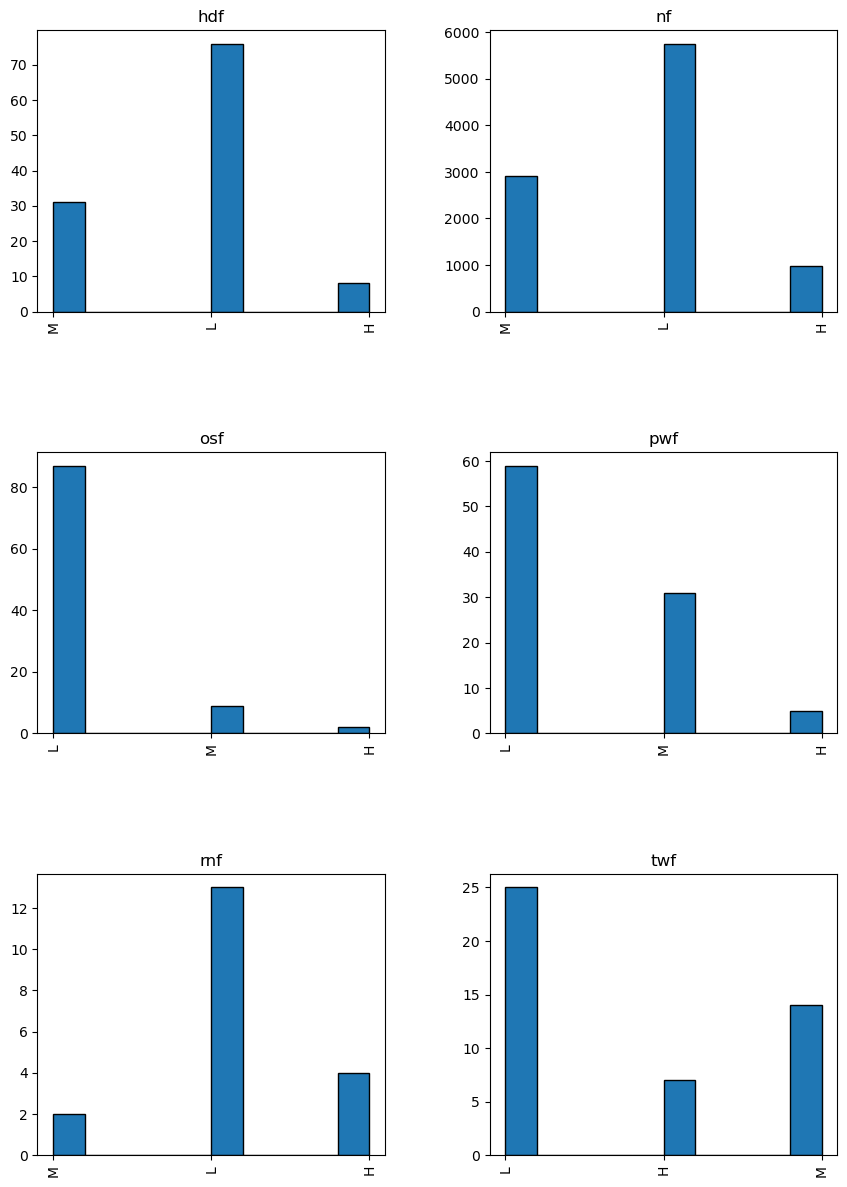

air_temperature


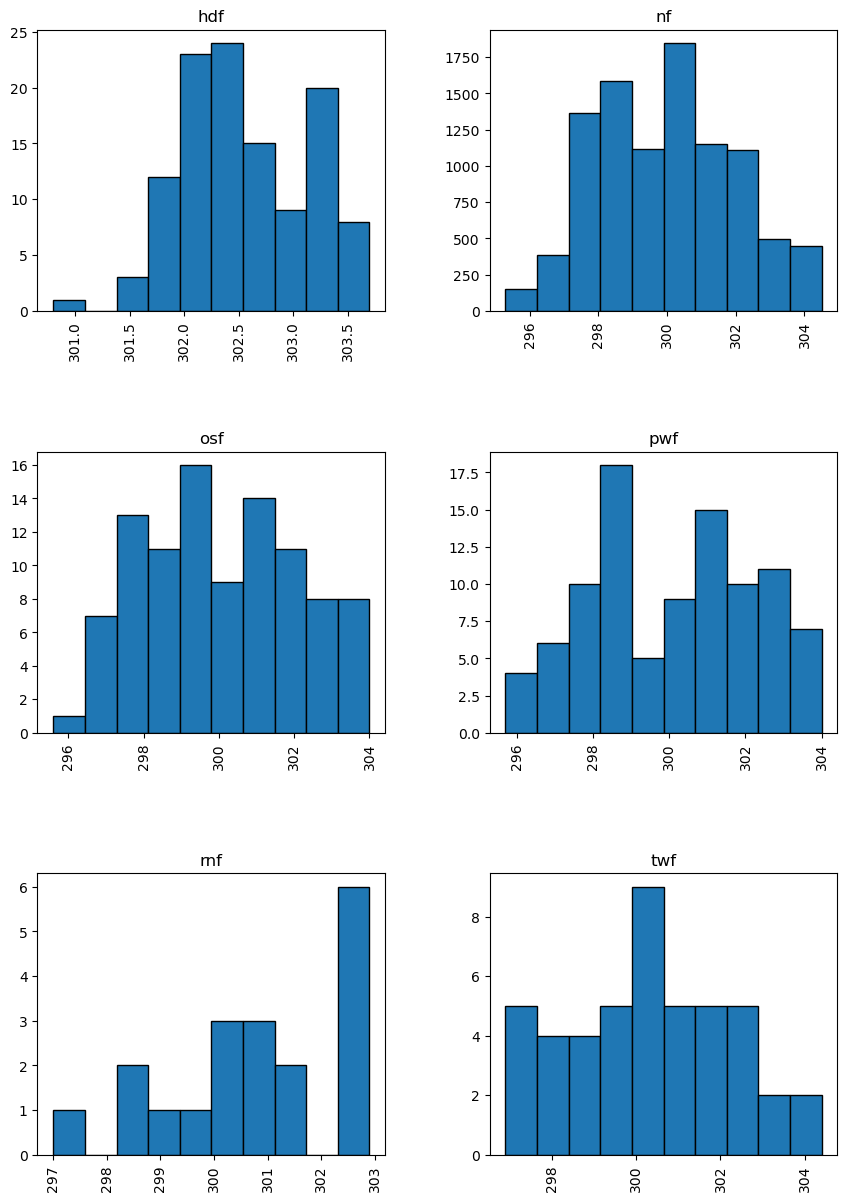

process_temperature


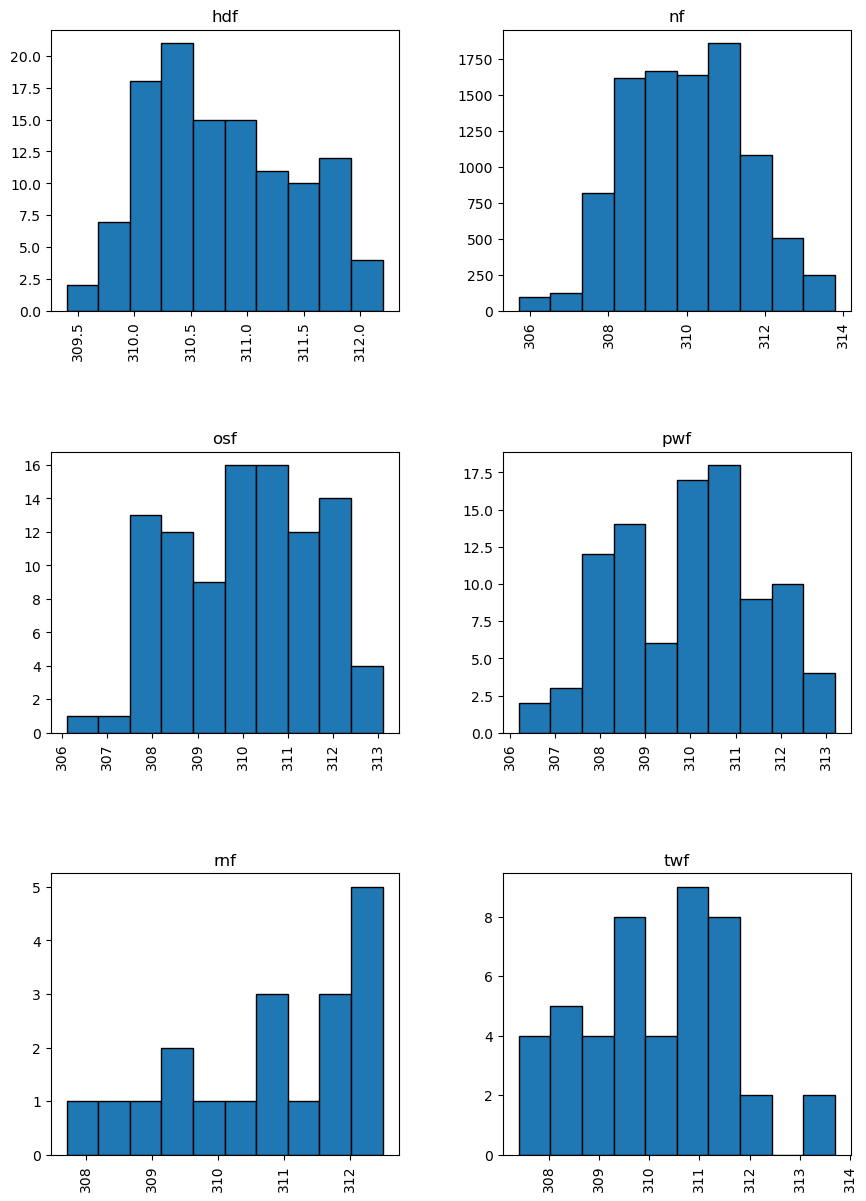

rotational_speed


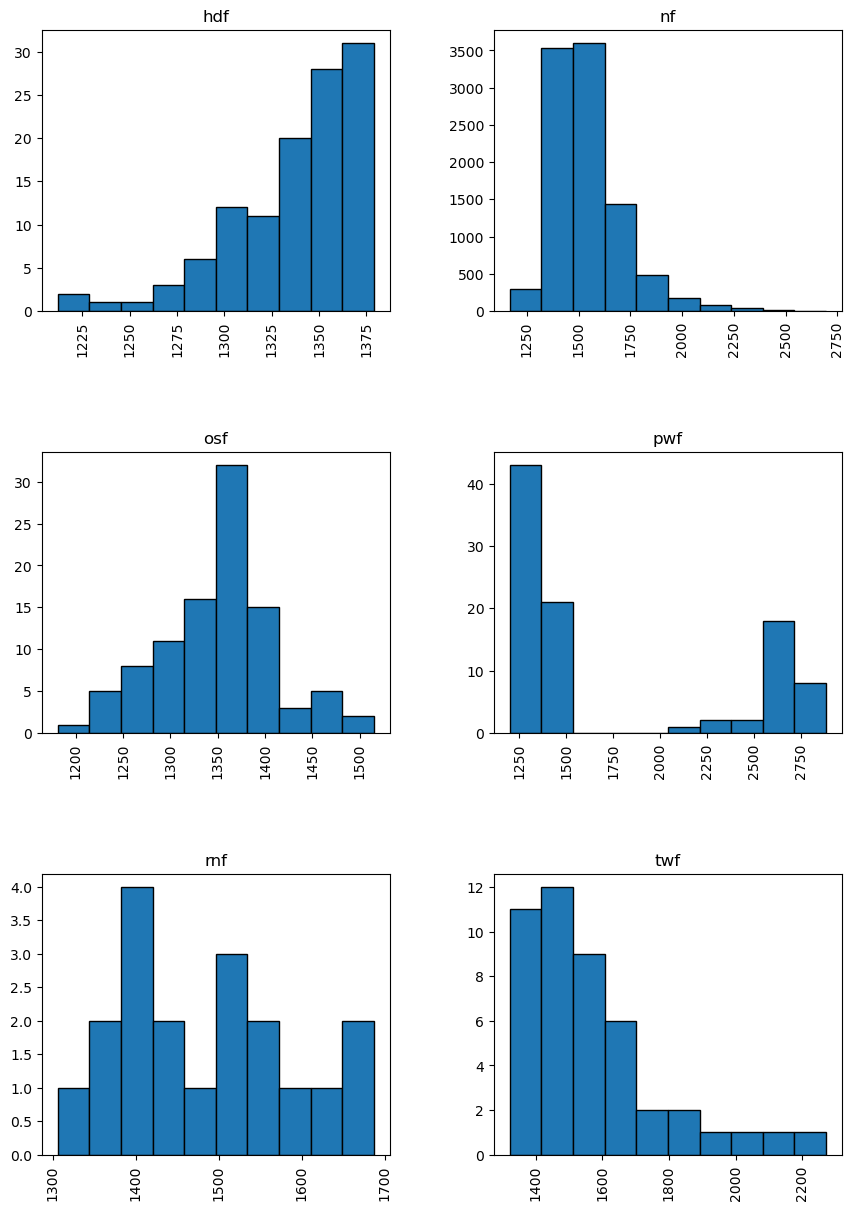

torque


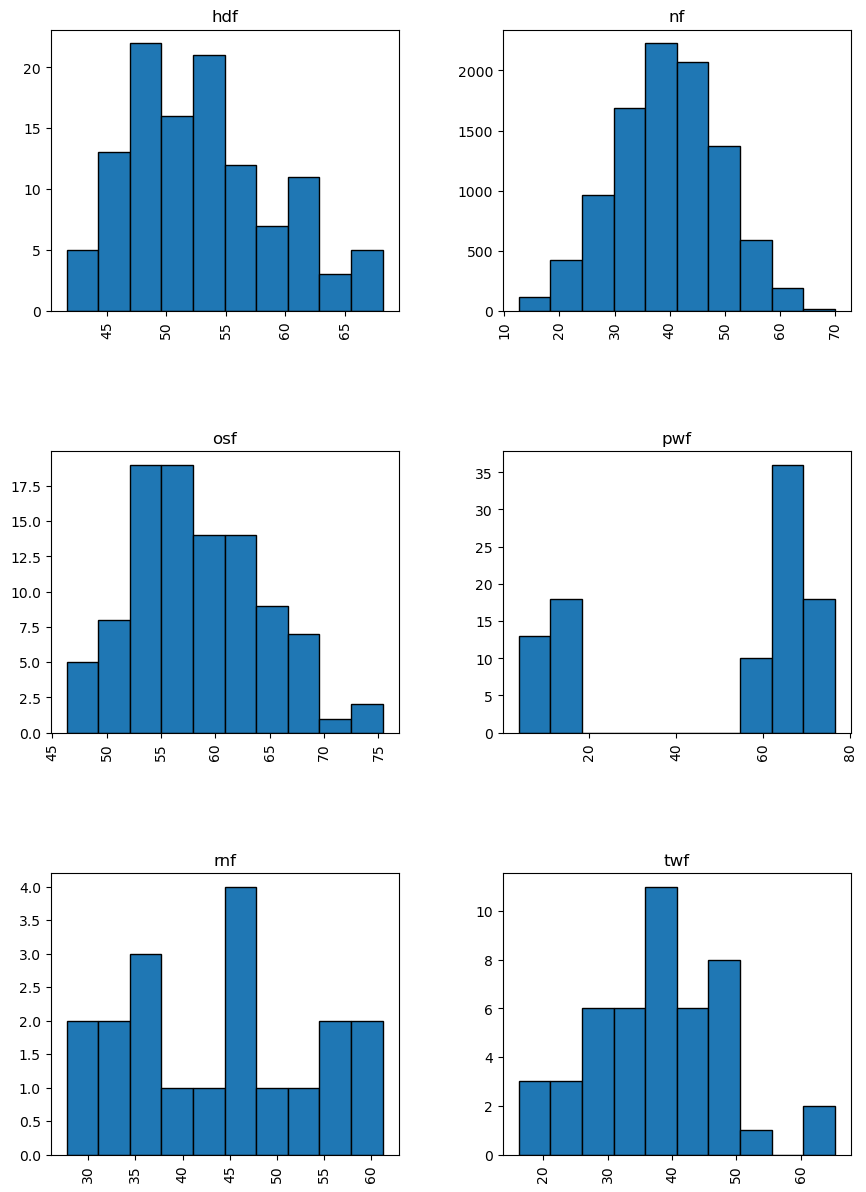

tool_wear


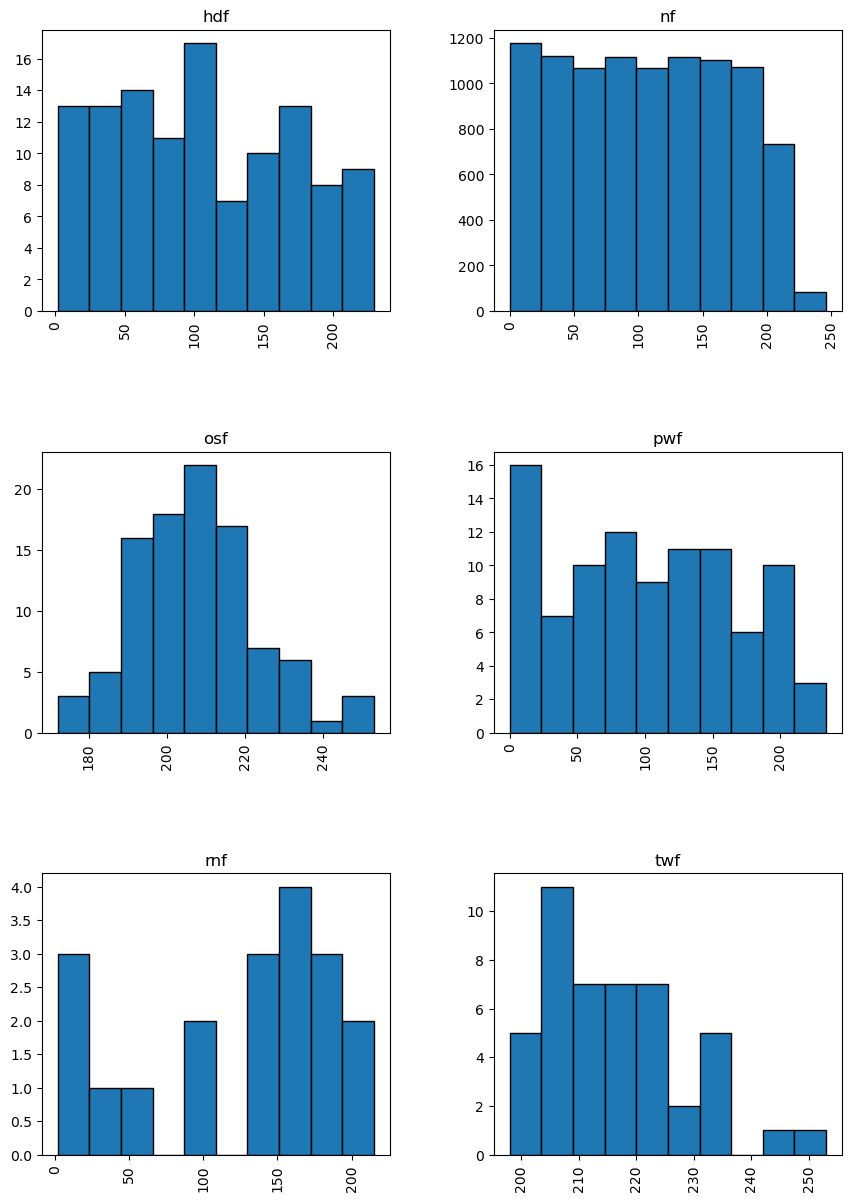

power


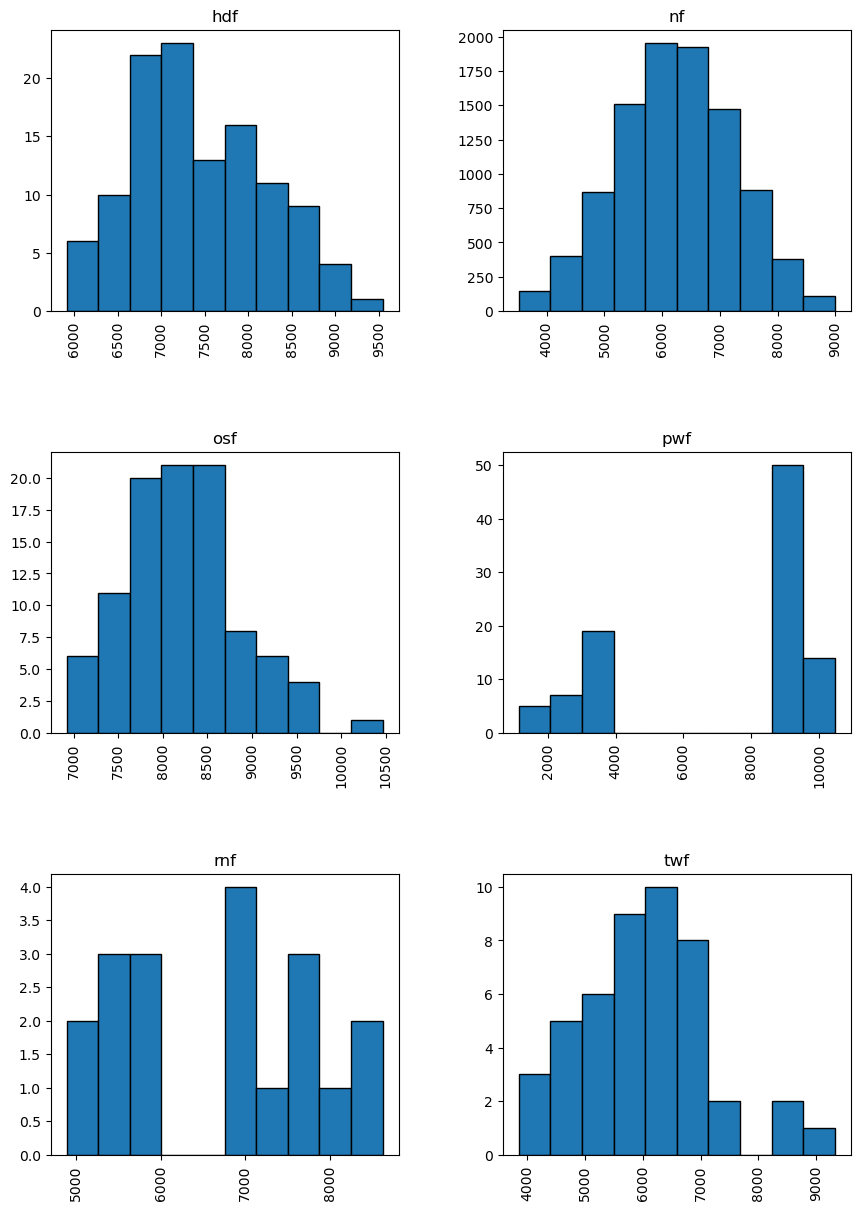

tool_torque


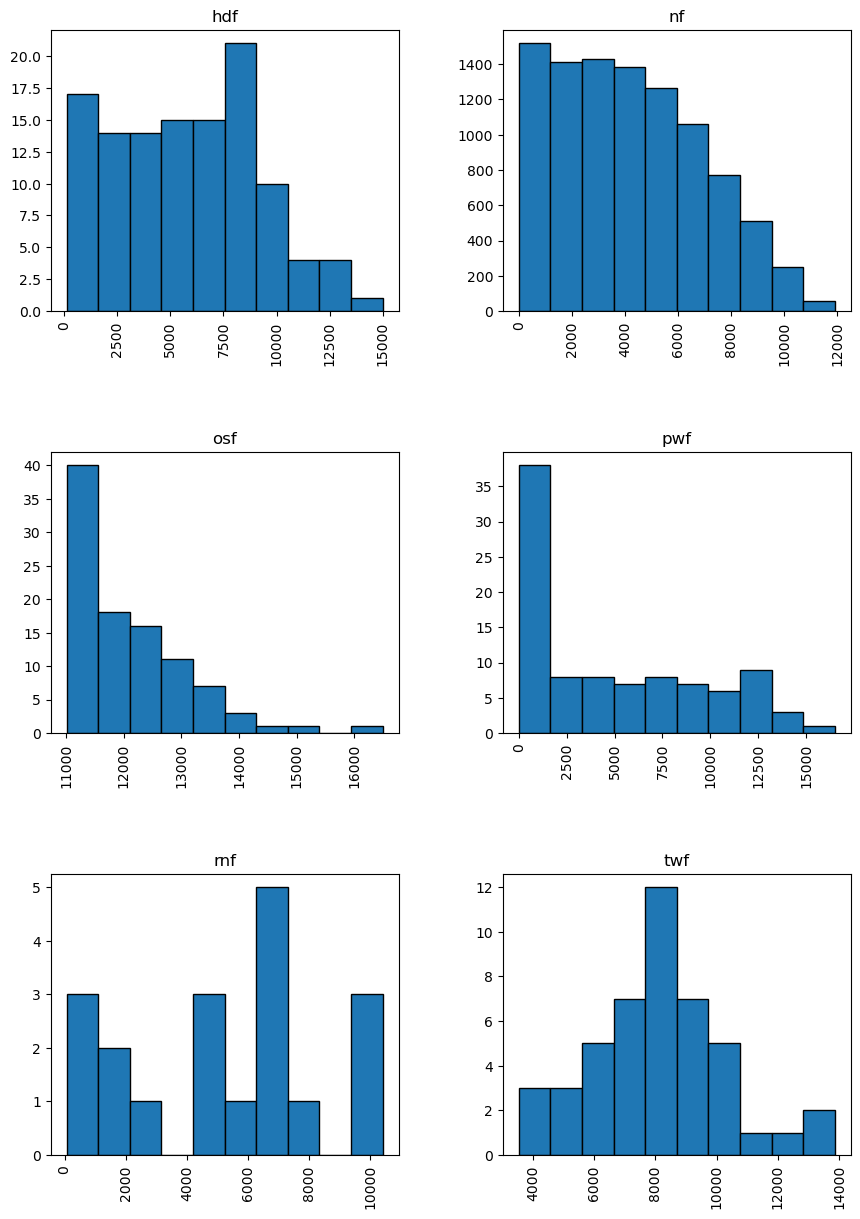

delta_temperature


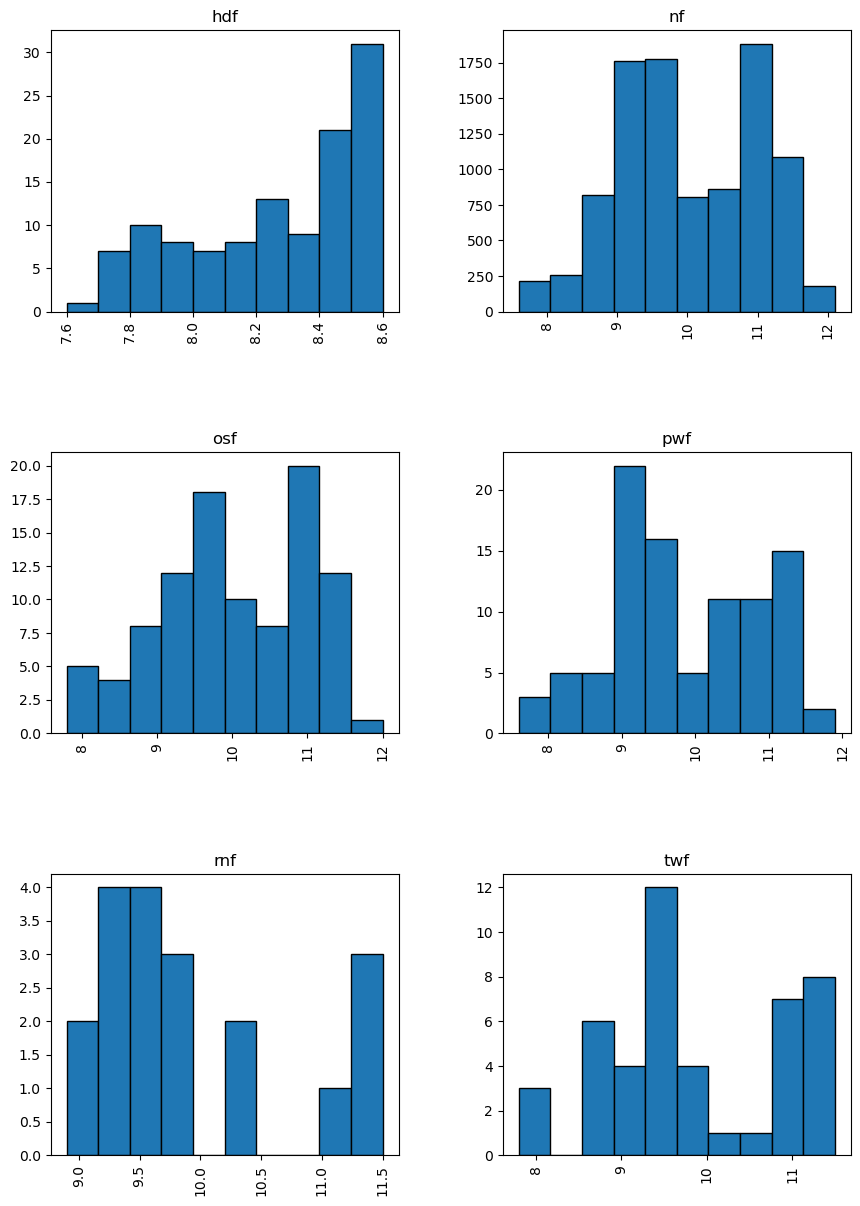

In [32]:
for att in df.drop(columns=['class']).columns:
    df.hist(column=att, by='class', bins=10, figsize=(10,15), edgecolor='black') # type: ignore
    print(att)
    plt.show()


# Classification

In [33]:
df.isna().value_counts()

index  type   air_temperature  process_temperature  rotational_speed  torque  tool_wear  power  tool_torque  delta_temperature  class
False  False  False            False                False             False   False      False  False        False              False    10025
dtype: int64

In [34]:

le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])
df["type"] = df["type"].astype(int)

le = LabelEncoder()
print(df)
df["class"] = le.fit_transform(df["class"])
df["class"] = df["class"].astype(int)

print(le.classes_)


       index  type  air_temperature  process_temperature  rotational_speed  \
0          0     2            298.1                308.6              1551   
1          1     1            298.2                308.7              1408   
2          2     1            298.1                308.5              1498   
3          3     1            298.2                308.6              1433   
4          4     1            298.2                308.7              1408   
...      ...   ...              ...                  ...               ...   
10020   9995     2            298.8                308.4              1604   
10021   9996     0            298.9                308.4              1632   
10022   9997     2            299.0                308.6              1645   
10023   9998     0            299.0                308.7              1408   
10024   9999     2            299.0                308.7              1500   

       torque  tool_wear        power  tool_torque  delta_tempe

In [35]:
df

index  type  air_temperature  process_temperature  rotational_speed  \
0          0     2            298.1                308.6              1551   
1          1     1            298.2                308.7              1408   
2          2     1            298.1                308.5              1498   
3          3     1            298.2                308.6              1433   
4          4     1            298.2                308.7              1408   
...      ...   ...              ...                  ...               ...   
10020   9995     2            298.8                308.4              1604   
10021   9996     0            298.9                308.4              1632   
10022   9997     2            299.0                308.6              1645   
10023   9998     0            299.0                308.7              1408   
10024   9999     2            299.0                308.7              1500   

       torque  tool_wear        power  tool_torque  delta_temperature  class  
0        42.8          0  6948.066400          0.0               10.5      1  
1        46.3          3  6823.261867        138.9               10.5      1  
2        49.4          5  7745.458933        247.0               10.4      1  
3        39.5          7  5924.499667        276.5               10.4      1  
4        40.0          9  5894.826667        360.0               10.5      1  
...       ...        ...          ...          ...                ...    ...  
10020    29.5         14  4952.617333        413.0                9.6      1  
10021    31.8         17  5431.948800        540.6                9.5      1  
10022    33.4         22  5750.700667        734.8                9.6      1  
10023    48.5         25  7147.477333       1212.5                9.7      1  
10024    40.2         30  6311.400000       1206.0                9.7      1  

[10025 rows x 11 columns]

In [36]:
X = pd.DataFrame()
X = X.assign(type=df["type"], air_temperature=df["air_temperature"], process_temperature=df["process_temperature"], rotational_speed=df["rotational_speed"], torque=df["torque"], tool_wear=df["tool_wear"], power=df['power'],tool_torque=df['tool_torque'],delta_temperature=df['delta_temperature'])
#type air_temperature_[k] process_temperature_[k] rotational_speed_[rpm] torque_[nm] tool_wear_[min]
y = pd.DataFrame()
y = y.assign(machine_fail=df["class"])

In [37]:
y

machine_fail
0                 1
1                 1
2                 1
3                 1
4                 1
...             ...
10020             1
10021             1
10022             1
10023             1
10024             1

[10025 rows x 1 columns]

In [38]:
X.shape, y.shape

((10025, 9), (10025, 1))

## Feature Selection
In the following I performe the features selection inside the 10-fold Cross-Validation, for mining the score of mutual information.<br>
In this way I can understand what feature are more correleted with the labeled-class, and using these attribute for the classification.

In [39]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

list_df = []
list_accuracy = []

dfKBest = pd.DataFrame()

k=0
for train, val in rskf.split(X, y):
    # fit and predict using pipeline
    X_train = X.iloc[train, :]
    y_train = y.iloc[train]
    # Create an object SelectKBest with the value of k
    #selector = SelectKBest(score_func=f_classif, k=10)
    selector = SelectKBest(score_func=mutual_info_classif ,  k=3)

    # Fit
    X_selected = selector.fit_transform(X_train, y_train) # type: ignore
    
    # scores = np.round(selector.scores_, decimals=1)
    # dfKBest = pd.DataFrame(selector.scores_, columns=['Score']) # type: ignore
    dfKBest['Score'+str(k)] = selector.scores_
    k+=1

dfKBest.index = ["type", "air_temperature", "process_temperature", "rotational_speed", "torque", "tool_wear","power","tool_torque","delta_temperature"]
display(dfKBest.sort_values(by='Score1', ascending=False))
    

Score0    Score1    Score2    Score3    Score4  \
power                0.076855  0.077993  0.077545  0.076069  0.076590   
torque               0.075924  0.075638  0.074155  0.073979  0.073444   
tool_torque          0.060307  0.059968  0.059184  0.059324  0.060711   
rotational_speed     0.054328  0.055595  0.053262  0.054219  0.051695   
tool_wear            0.028456  0.029647  0.031417  0.030003  0.030580   
delta_temperature    0.028590  0.028699  0.028602  0.026934  0.029155   
air_temperature      0.018997  0.017028  0.019283  0.019273  0.018926   
process_temperature  0.010143  0.008531  0.008454  0.008185  0.005650   
type                 0.003298  0.004858  0.004195  0.005691  0.008132   

                       Score5    Score6    Score7    Score8    Score9  ...  \
power                0.076580  0.078011  0.078289  0.077416  0.078280  ...   
torque               0.074143  0.076197  0.077881  0.074535  0.074396  ...   
tool_torque          0.058144  0.058887  0.059750  0.060000  0.058905  ...   
rotational_speed     0.054561  0.057292  0.054699  0.054660  0.057083  ...   
tool_wear            0.030284  0.031740  0.031285  0.026625  0.028762  ...   
delta_temperature    0.028761  0.027533  0.026613  0.027233  0.026933  ...   
air_temperature      0.018929  0.022235  0.017042  0.019932  0.018557  ...   
process_temperature  0.007679  0.008127  0.013377  0.005900  0.008268  ...   
type                 0.005492  0.000572  0.001527  0.003893  0.003089  ...   

                      Score20   Score21   Score22   Score23   Score24  \
power                0.076644  0.077613  0.075648  0.077832  0.075556   
torque               0.072335  0.075698  0.073805  0.073866  0.075938   
tool_torque          0.059637  0.057823  0.058011  0.059947  0.058418   
rotational_speed     0.051976  0.052483  0.054135  0.054697  0.054014   
tool_wear            0.030734  0.030520  0.029576  0.029618  0.029053   
delta_temperature    0.031349  0.027219  0.028499  0.028404  0.029414   
air_temperature      0.017207  0.019602  0.018883  0.021005  0.019008   
process_temperature  0.008717  0.007492  0.005856  0.010640  0.008835   
type                 0.004226  0.003344  0.003873  0.002153  0.002512   

                      Score25   Score26   Score27   Score28   Score29  
power                0.076983  0.077488  0.076310  0.079406  0.078137  
torque               0.076066  0.074953  0.075048  0.075713  0.077213  
tool_torque          0.059585  0.060164  0.060767  0.060645  0.059412  
rotational_speed     0.053806  0.055623  0.054374  0.055225  0.054848  
tool_wear            0.028001  0.030515  0.030372  0.028229  0.030760  
delta_temperature    0.027732  0.027120  0.027587  0.027658  0.028562  
air_temperature      0.017757  0.018372  0.020466  0.018310  0.017823  
process_temperature  0.007793  0.009119  0.008558  0.007003  0.009001  
type                 0.002926  0.007572  0.002115  0.004076  0.002616  

[9 rows x 30 columns]

We are going to remove only the last three feature

In [40]:
last_feature = dfKBest.sort_values(by='Score1', ascending=False).tail(n=3)
last_feature
X = X.drop(columns = last_feature.index)

## SMOTE

In [41]:
!pip install imbalanced-learn

In [42]:
from imblearn.over_sampling import SMOTE

oversamp = SMOTE(n_jobs=-1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 0,
                                                    stratify=y)
X_train,y_train = oversamp.fit_resample(X_train, y_train)

y_train

machine_fail
0                 1
1                 1
2                 1
3                 1
4                 1
...             ...
40531             5
40532             5
40533             5
40534             5
40535             5

[40536 rows x 1 columns]

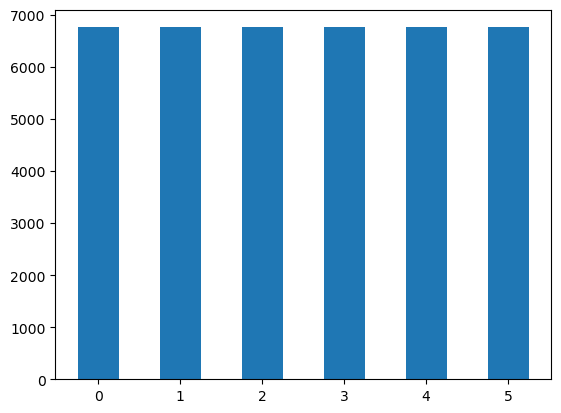

In [43]:
freq = y_train["machine_fail"].value_counts()
plt.bar(freq.index, freq.values, width=0.5)

plt.xticks(rotation=0)
plt.show()

In [44]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# KNN

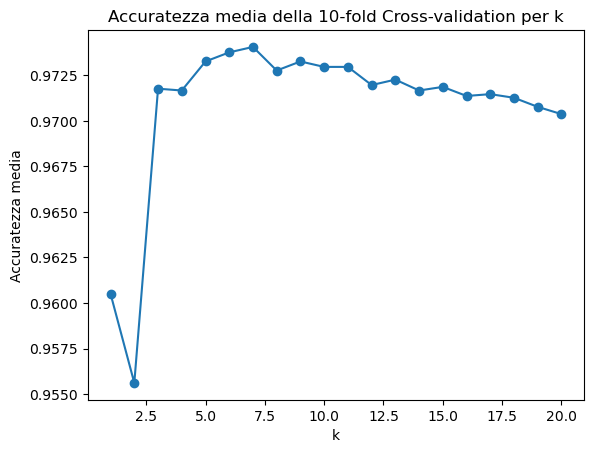

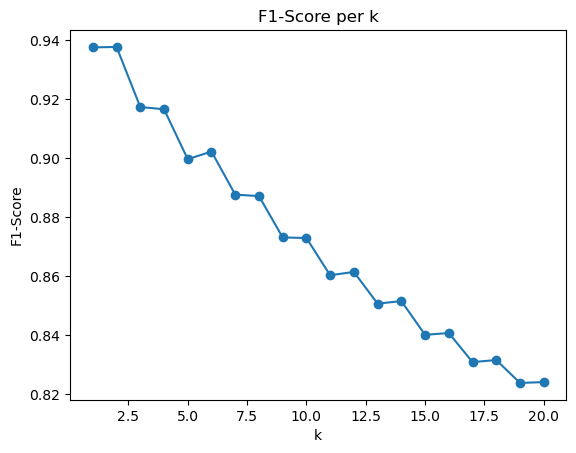

Classification report per k = 1
              precision    recall  f1-score   support

           0       0.56      0.57      0.56        35
           1       0.99      0.93      0.96      2896
           2       0.46      0.62      0.53        29
           3       0.57      0.61      0.59        28
           4       0.00      0.00      0.00         6
           5       0.03      0.14      0.05        14

    accuracy                           0.91      3008
   macro avg       0.43      0.48      0.45      3008
weighted avg       0.97      0.91      0.94      3008

Classification report per k = 2
              precision    recall  f1-score   support

           0       0.47      0.71      0.57        35
           1       0.99      0.92      0.96      2896
           2       0.49      0.69      0.57        29
           3       0.55      0.57      0.56        28
           4       0.00      0.00      0.00         6
           5       0.03      0.14      0.05        14

    accuracy 

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

acc_scores = []
f1_scores = []
reports = []


for k in range(1, 21):
   
    model = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_val_score(model, X, y, cv=10)
    acc_mean = cv_results.mean()
    acc_scores.append(acc_mean)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    f1_scores.append(f1)
    reports.append(report)

plt.plot(range(1, 21),acc_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Accuratezza media')
plt.title('Accuratezza media della 10-fold Cross-validation per k')
plt.show()

plt.plot(range(1, 21), f1_scores, marker='o')
plt.xlabel('k')
plt.ylabel('F1-Score')
plt.title('F1-Score per k')
plt.show()

for k in range(1, 21):
    print(f'Classification report per k = {k}')
    print(reports[k-1])

for k in range(1, 21):
    print(f'Accuratezza media per ogni step della cross validation per k = {k}')
    print(np.array(cv_results).reshape(10, 1))


In [46]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score'])


We'll choose 3 as k for the KNN model because this classifier has a better F1 Score (For unbalanced dataset is better to use the F1 Score)

In [47]:
model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
y_predictions = model.predict(X_test) # These are the predictions from the test data.

In [48]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
model_performance.loc['Logistic'] = [accuracy, recall, precision, f1s]

Accuracy: 87.43%
Recall: 87.43%
Precision: 96.92%
F1-Score: 91.74%


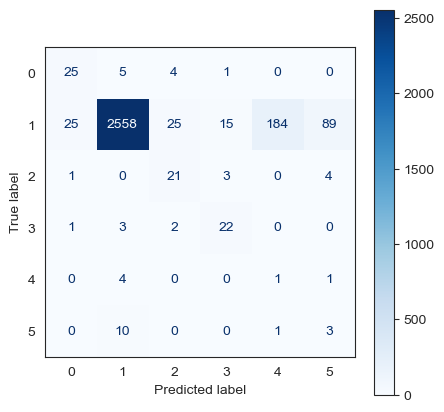

In [49]:
plt.rcParams['figure.figsize']=5,5 
plt.rcParams['font.size'] = 10
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

# Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

# Creo un modello DecisionTreeClassifier con criterion = 'gini'
model = DecisionTreeClassifier(criterion='gini')
# Applico la 10-fold Cross-validation al modello e ai dati X e y
cv_results = cross_val_score(model, X, y, cv=10)
# Calcolo l'accuratezza media della cross-validation
acc_mean = cv_results.mean()
# Addestro il modello sui dati di training
model.fit(X_train, y_train)
# Faccio le predizioni sui dati di test
y_pred = model.predict(X_test)
# Calcolo l'F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
# Calcolo il classification report
report = classification_report(y_test, y_pred)

# Stampo i valori di accuratezza, F1-Score e classification report
print(f'Accuratezza media della cross-validation: {acc_mean:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Classification report:\n{report}')

# Stampo anche l'accuratezza media per ogni step della cross validation
print(f'Accuratezza media per ogni step della cross validation:')
print(np.array(cv_results).reshape(10, 1))


Accuratezza media della cross-validation: 0.93
F1-Score: 0.96
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        35
           1       0.99      0.96      0.97      2896
           2       0.62      0.62      0.62        29
           3       0.82      0.82      0.82        28
           4       0.00      0.00      0.00         6
           5       0.02      0.07      0.03        14

    accuracy                           0.95      3008
   macro avg       0.56      0.55      0.55      3008
weighted avg       0.98      0.95      0.96      3008

Accuratezza media per ogni step della cross validation:
[[0.97507478]
 [0.97706879]
 [0.98005982]
 [0.97407777]
 [0.49850449]
 [0.97205589]
 [0.98003992]
 [0.98303393]
 [0.98203593]
 [0.9750499 ]]


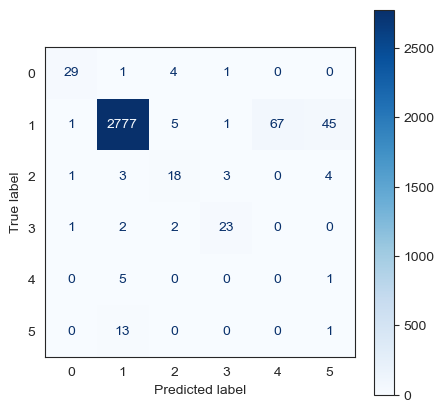

In [51]:
plt.rcParams['figure.figsize']=5,5 
plt.rcParams['font.size'] = 10
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

# Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

model = RandomForestClassifier(n_estimators=100, criterion='gini') 
cv_results = cross_val_score(model, X, y, cv=10)
acc_mean = cv_results.mean()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

print(f'Accuratezza media della cross-validation: {acc_mean:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Classification report:\n{report}')

print(f'Accuratezza media per ogni step della cross validation:')
print(np.array(cv_results).reshape(10, 1))


Accuratezza media della cross-validation: 0.98
F1-Score: 0.97
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88        35
           1       0.99      0.96      0.98      2896
           2       0.66      0.72      0.69        29
           3       0.83      0.89      0.86        28
           4       0.00      0.00      0.00         6
           5       0.06      0.21      0.09        14

    accuracy                           0.95      3008
   macro avg       0.57      0.61      0.58      3008
weighted avg       0.98      0.95      0.97      3008

Accuratezza media per ogni step della cross validation:
[[0.98305085]
 [0.98604187]
 [0.98703888]
 [0.98703888]
 [0.92023928]
 [0.98702595]
 [0.98702595]
 [0.98502994]
 [0.98502994]
 [0.98502994]]


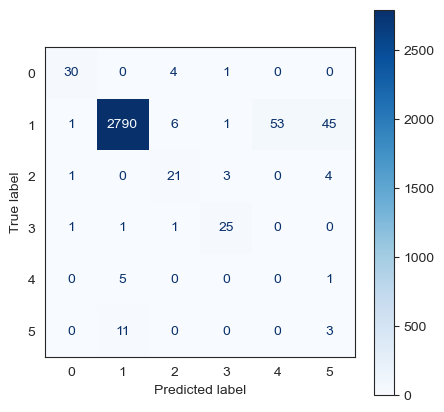

In [53]:
plt.rcParams['figure.figsize']=5,5 
plt.rcParams['font.size'] = 10
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

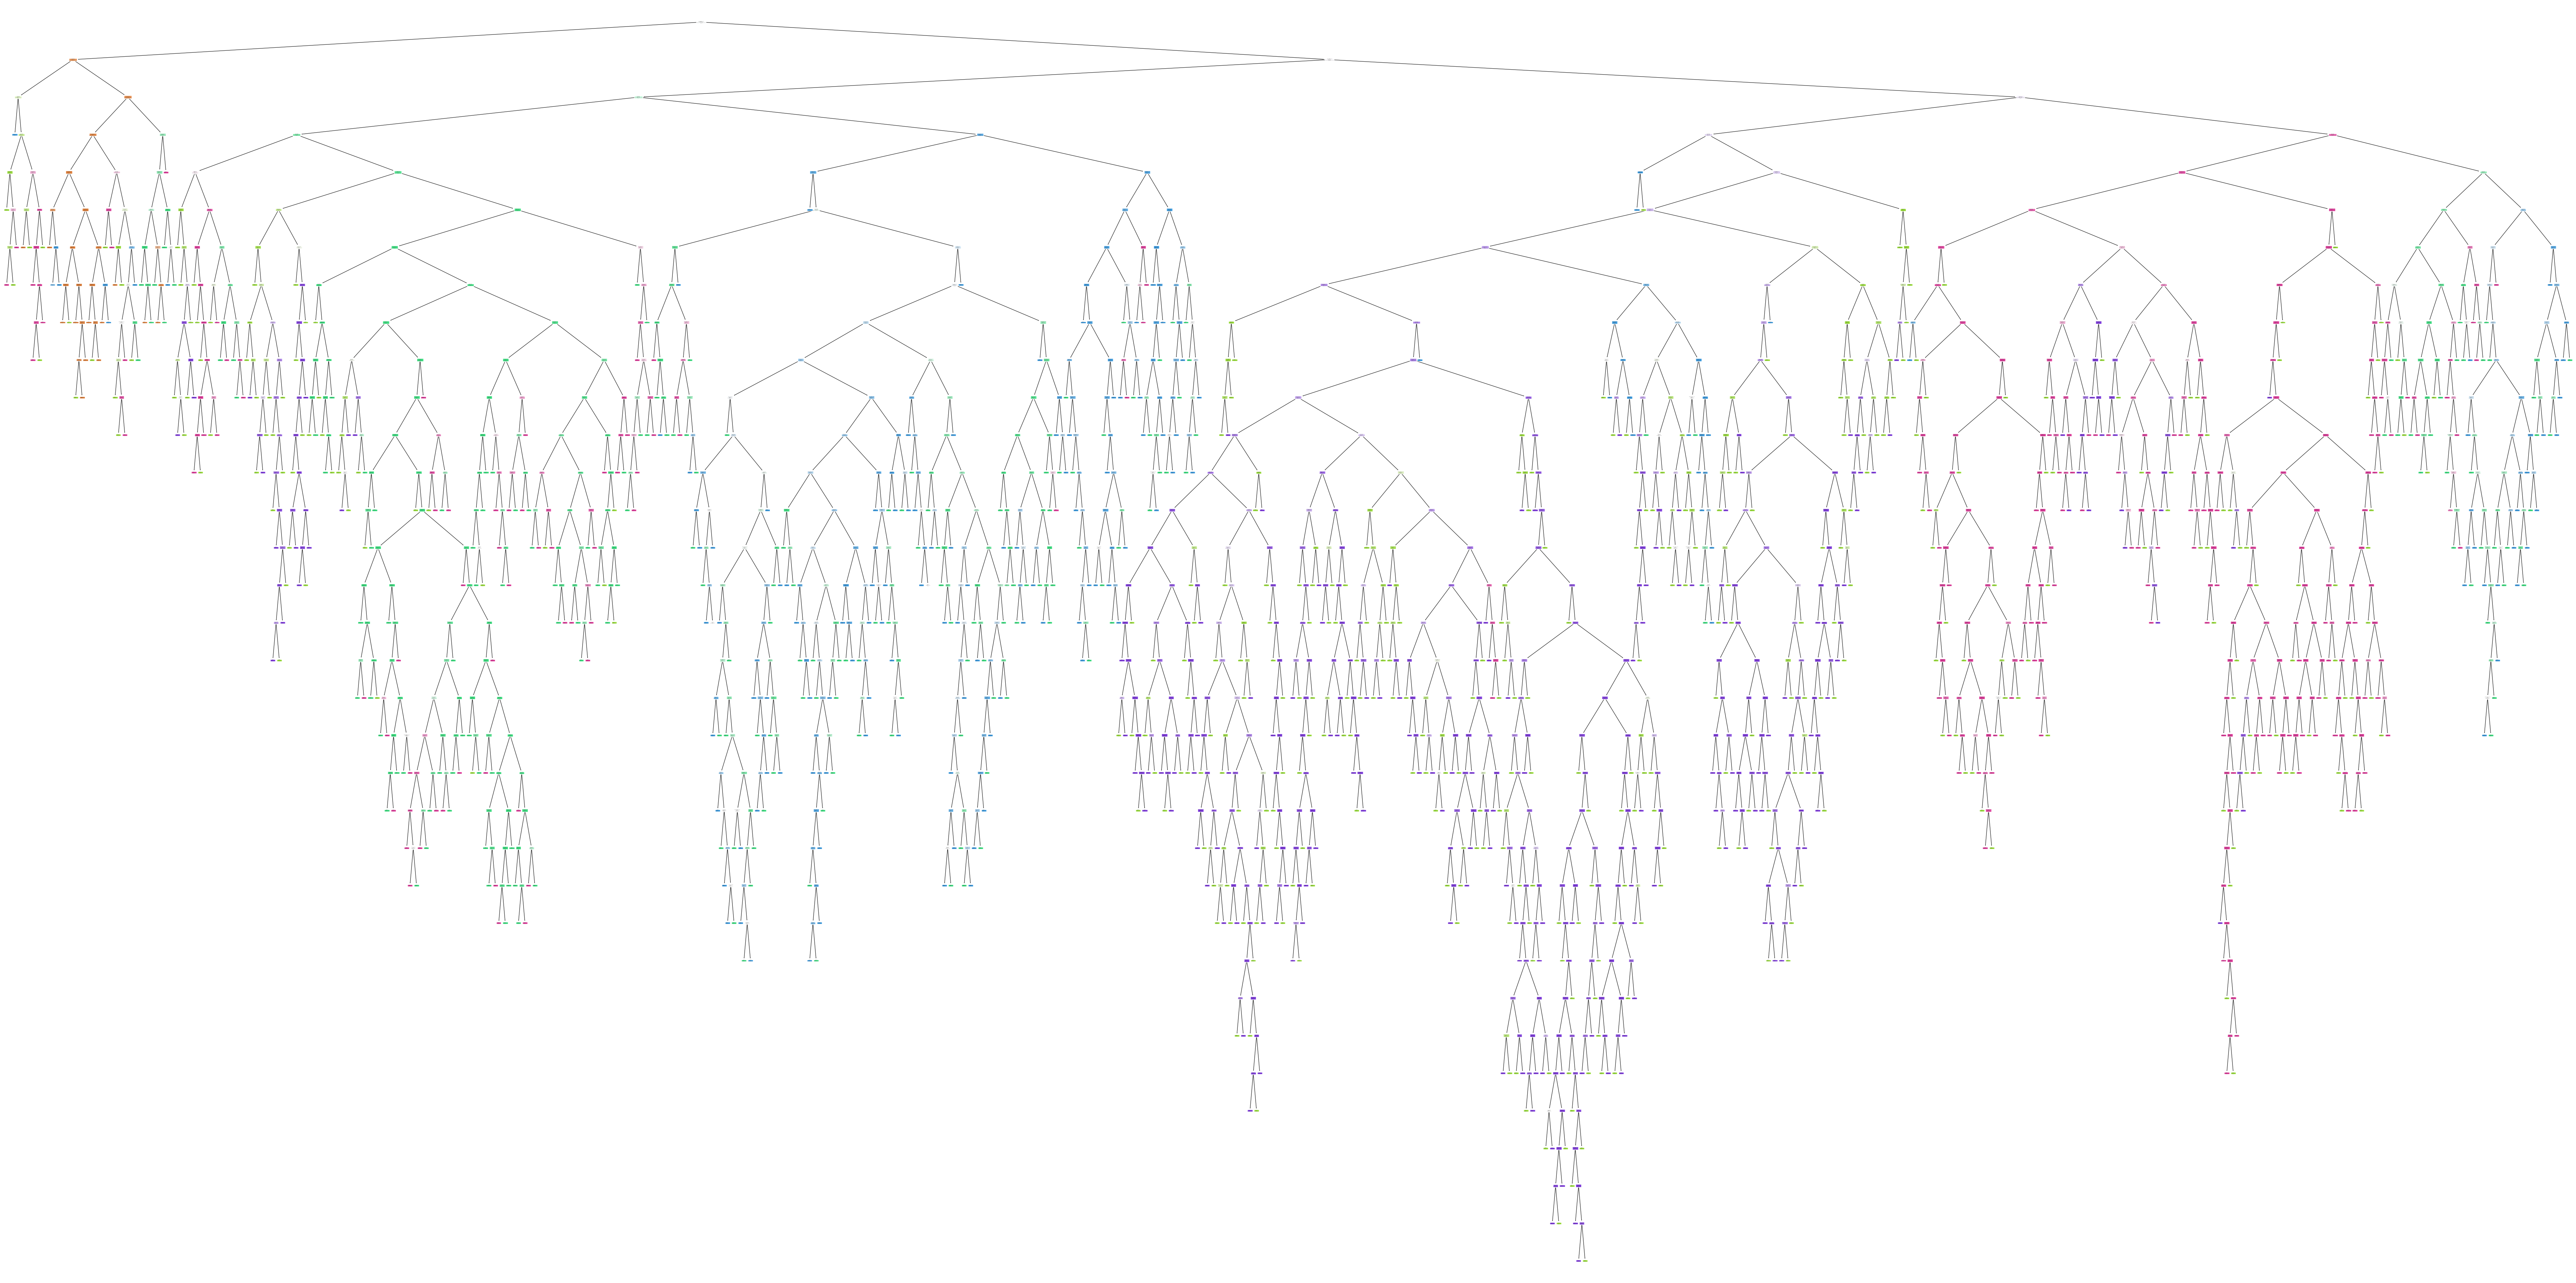

In [54]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Calcola l'accuratezza di ogni albero
accuracies = [tree.score(X_test, y_test) for tree in model.estimators_]
max_index = np.argmax(accuracies)
plt.figure(figsize = (100, 50))
plot_tree(model.estimators_[max_index], feature_names = X.columns, class_names = list(map(str, y["machine_fail"].unique()))
, filled = True)
plt.show()


# Naive Bayes Classifier

In [56]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

# Creo un modello GaussianNB
model = GaussianNB()
# Creo una lista vuota per salvare i valori di F1-Score
f1_scores = []
# Applico la 10-fold Cross-validation al modello e ai dati X e y
cv_results = cross_val_score(model, X, y, cv=10, scoring='f1_weighted')
# Calcolo l'accuratezza media della cross-validation
acc_mean = cv_results.mean()
# Itero sui valori di F1-Score restituiti dalla cross-validation
for f1 in cv_results:
    # Aggiungo il valore di f1 alla lista f1_scores
    f1_scores.append(f1)
# Addestro il modello sui dati di training
model.fit(X_train, y_train)
# Faccio le predizioni sui dati di test
y_pred = model.predict(X_test)
# Calcolo l'F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
# Calcolo il classification report
report = classification_report(y_test, y_pred)

# Stampo i valori di accuratezza, F1-Score e classification report
print(f'Accuratezza media della cross-validation: {acc_mean:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Classification report:\n{report}')

# Stampo anche l'F1-Score per ogni passaggio della cross validation
print(f'F1-Score per ogni passaggio della cross validation:')
print(np.array(f1_scores).reshape(10, 1))


Accuratezza media della cross-validation: 0.95
F1-Score: 0.57
Classification report:
              precision    recall  f1-score   support

           0       0.42      0.86      0.56        35
           1       1.00      0.41      0.58      2896
           2       0.29      0.90      0.44        29
           3       0.10      0.96      0.19        28
           4       0.00      0.17      0.00         6
           5       0.05      0.93      0.09        14

    accuracy                           0.43      3008
   macro avg       0.31      0.70      0.31      3008
weighted avg       0.97      0.43      0.57      3008

F1-Score per ogni passaggio della cross validation:
[[0.96054813]
 [0.95767778]
 [0.96160058]
 [0.95283871]
 [0.91741031]
 [0.95732164]
 [0.95292881]
 [0.95719459]
 [0.95950874]
 [0.96132035]]


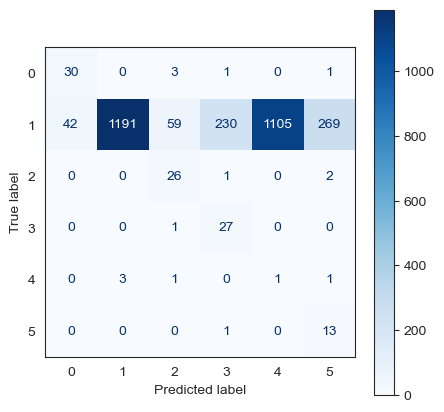

In [57]:
plt.rcParams['figure.figsize']=5,5 
plt.rcParams['font.size'] = 10
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

# AdaBoost

In [58]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report


model = AdaBoostClassifier( random_state=42)
# Creo una lista vuota per salvare i valori di F1-Score
f1_scores = []
# Applico la 10-fold Cross-validation al modello e ai dati X e y
cv_results = cross_val_score(model, X, y, cv=10, scoring='f1_weighted')
# Calcolo l'accuratezza media della cross-validation
acc_mean = cv_results.mean()
# Itero sui valori di F1-Score restituiti dalla cross-validation
for f1 in cv_results:
    # Aggiungo il valore di f1 alla lista f1_scores
    f1_scores.append(f1)
# Addestro il modello sui dati di training
model.fit(X_train, y_train)
# Faccio le predizioni sui dati di test
y_pred = model.predict(X_test)
# Calcolo l'F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
# Calcolo il classification report
report = classification_report(y_test, y_pred)

# Stampo i valori di accuratezza, F1-Score e classification report
print(f'Accuratezza media della cross-validation: {acc_mean:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Classification report:\n{report}')

# Stampo anche l'F1-Score per ogni passaggio della cross validation
print(f'F1-Score per ogni passaggio della cross validation:')
print(np.array(f1_scores).reshape(10, 1))


Accuratezza media della cross-validation: 0.87
F1-Score: 0.34
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87        35
           1       0.99      0.20      0.33      2896
           2       0.72      0.79      0.75        29
           3       1.00      0.39      0.56        28
           4       0.00      0.50      0.00         6
           5       0.07      0.93      0.13        14

    accuracy                           0.22      3008
   macro avg       0.60      0.63      0.44      3008
weighted avg       0.98      0.22      0.34      3008

F1-Score per ogni passaggio della cross validation:
[[0.96791429]
 [0.96688895]
 [0.95833506]
 [0.95896614]
 [0.525077  ]
 [0.96031766]
 [0.50334426]
 [0.95825629]
 [0.96181314]
 [0.96785857]]


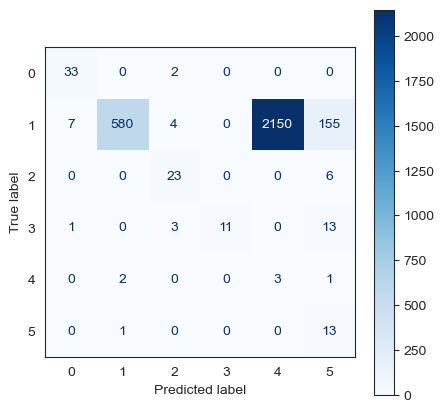

In [59]:
plt.rcParams['figure.figsize']=5,5 
plt.rcParams['font.size'] = 10
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

# Conclusion
The best classifier as we can see from the F1-Score is the RandomForestCassifier

In [60]:
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(n_estimators=100, criterion='gini') 
model.fit(X_train, y_train)

RandomForestClassifier()

# Export Model

In [61]:
import joblib
model_file_name = "model.joblib"
model_folder = "./models/"
joblib.dump(model, model_folder+''+model_file_name)

['./models/model.joblib']

In [62]:
import joblib
model_file_name = "scaler.joblib"
model_folder = "./models/"
joblib.dump(sc, model_folder+''+model_file_name)

['./models/scaler.joblib']